In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from tqdm.notebook import tqdm
import plotly.express as px
from scipy.spatial import ConvexHull
from scipy.spatial.distance import cdist
from pathlib import Path
from os import getenv
import warnings
warnings.filterwarnings("ignore")
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score,f1_score,brier_score_loss,mean_squared_error,mean_absolute_error
from xgboost import XGBClassifier
import shap
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
import optuna

In [2]:
def hex_to_rgb_array(hex_color):
    '''take in hex val and return rgb np array'''
    return np.array(tuple(int(hex_color.lstrip('#')[i:i+2], 16) for i in (0, 2, 4)))

def ColorDistance(hex1,hex2):
    '''d = {} distance between two colors(3)'''
    if hex1 == hex2:
        return 0
    rgb1 = hex_to_rgb_array(hex1)
    rgb2 = hex_to_rgb_array(hex2)
    rm = 0.5*(rgb1[0]+rgb2[0])
    d = abs(sum((2+rm,4,3-rm)*(rgb1-rgb2)**2))**0.5
    return d

def ColorPairs(team1,team2):
    color_array_1 = colors[team1]
    color_array_2 = colors[team2]
    # If color distance is small enough then flip color order
    if ColorDistance(color_array_1[0],color_array_2[0])<500:
        return {team1:[color_array_1[0],color_array_1[1]],team2:[color_array_2[1],color_array_2[0]],'football':colors['football']}
    else:
        return {team1:[color_array_1[0],color_array_1[1]],team2:[color_array_2[0],color_array_2[1]],'football':colors['football']}
colors = {
    'ARI':["#97233F","#000000","#FFB612"],
    'ATL':["#A71930","#000000","#A5ACAF"],
    'BAL':["#241773","#000000"],
    'BUF':["#00338D","#C60C30"],
    'CAR':["#0085CA","#101820","#BFC0BF"],
    'CHI':["#0B162A","#C83803"],
    'CIN':["#FB4F14","#000000"],
    'CLE':["#311D00","#FF3C00"],
    'DAL':["#003594","#041E42","#869397"],
    'DEN':["#FB4F14","#002244"],
    'DET':["#0076B6","#B0B7BC","#000000"],
    'GB' :["#203731","#FFB612"],
    'HOU':["#03202F","#A71930"],
    'IND':["#002C5F","#A2AAAD"],
    'JAX':["#101820","#D7A22A","#9F792C"],
    'KC' :["#E31837","#FFB81C"],
    'LA' :["#003594","#FFA300","#FF8200"],
    'LAC':["#0080C6","#FFC20E","#FFFFFF"],
    'LV' :["#000000","#A5ACAF"],
    'MIA':["#008E97","#FC4C02","#005778"],
    'MIN':["#4F2683","#FFC62F"],
    'NE' :["#002244","#C60C30","#B0B7BC"],
    'NO' :["#101820","#D3BC8D"],
    'NYG':["#0B2265","#A71930","#A5ACAF"],
    'NYJ':["#125740","#000000","#FFFFFF"],
    'PHI':["#004C54","#A5ACAF","#ACC0C6"],
    'PIT':["#FFB612","#101820"],
    'SEA':["#002244","#69BE28","#A5ACAF"],
    'SF' :["#AA0000","#B3995D"],
    'TB' :["#D50A0A","#FF7900","#0A0A08"],
    'TEN':["#0C2340","#4B92DB","#C8102E"],
    'WAS':["#5A1414","#FFB612"],
    'football':["#CBB67C","#663831"]
}


In [3]:
def get_convex_hull(df,football_location):
    # Separate football, offense, and defense points

    # Calculate pairwise distances using Euclidean distance for defense
    distances= cdist(football_location[['x', 'y']], df[['x', 'y']], metric='euclidean')

    # Get the indices of the 5 nearest neighbors for defense
    indices = distances.argsort(axis=1)[:, :3]

    # Get the nearest points for defense
    nearest_points = df.iloc[indices.flatten()]

    # Calculate convex hull
    hull = ConvexHull(nearest_points[['x', 'y']])
    # Get the area of the convex hull
    hull_area = hull.area
    return hull_area

In [4]:
class DataProcessor:
    PLAYIDS = ["gameId", "playId"]
    CARRY_START_EVENTS = {
        "run",
        "handoff",
        "pass_outcome_caught",
        "snap_direct"
    }
    @classmethod
    def change_direction_plays(cls,tracking):
        tracking['x'] = np.where(tracking['playDirection']=='left',120-tracking['x'],tracking['x'])
        tracking['y'] = np.where(tracking['playDirection']=='left',160 /3 - tracking['y'],tracking['y'])
        tracking['dir'] = np.where(tracking['playDirection']=='left',tracking['dir']+180,tracking['dir'])
        tracking['dir'] = np.where(tracking['dir']>360,tracking['dir']-360,tracking['dir'])
        tracking['o'] = np.where(tracking['playDirection'] == 'left',tracking['o']+180,tracking['o'])
        tracking['o'] = np.where(tracking['o']>360,tracking['o']-360,tracking['o'])
        return tracking
    @classmethod
    def construct_ball_carrier_view(cls, plays, tracking):
        """
        Construct a view of tracking data focused on ball carriers,
        subset to the frames where they have the ball
        """
        
        ball_carriers = tracking.merge(
            play_df[cls.PLAYIDS + ["ballCarrierId"]],
            left_on=cls.PLAYIDS + ["nflId"],
            right_on=cls.PLAYIDS + ["ballCarrierId"]
        )
        # take last non-NA event as end of play
        play_end = ball_carriers.dropna(subset="event").drop_duplicates(
            subset=cls.PLAYIDS, keep="last"
        )[cls.PLAYIDS + ["frameId", "event", "x"]].rename(
            columns=dict(frameId="endFrameId", event="endEvent", x="x_final")
        )
        # consider class of events that are valid for ball carrier to have received the ball
        carry_start = ball_carriers[
            ball_carriers.event.isin({"run", "handoff", "pass_outcome_caught", "snap_direct"})
        ].drop_duplicates(
            subset=cls.PLAYIDS, keep="last"
        )[cls.PLAYIDS + ["frameId", "event"]].rename(
            columns=dict(frameId="startFrameId", event="receiptEvent")
        )
        carry_window = carry_start.merge(play_end, on=cls.PLAYIDS)

        # extract only those frames between ball receipt and end of play
        ball_carriers = ball_carriers.merge(
            carry_window,
            on=cls.PLAYIDS
        )

        angle_to_downfield = np.pi * np.where(
            ball_carriers.playDirection == "right",
            ball_carriers.dir - 90,
            ball_carriers.dir - 270
        ) / 180
        ball_carriers["s_downfield"] = ball_carriers.s * np.cos(angle_to_downfield)
        
        return ball_carriers[
            ball_carriers.frameId.between(ball_carriers.startFrameId, ball_carriers.endFrameId)
        ].reset_index(drop=True).astype({"nflId": "int", "jerseyNumber": "int"})
        
    @classmethod
    def construct_defender_view(cls, carriers, tracking, nearby_radius=5):
        """
        Given a carrier view, determine where the defenders are relative to the carrier
        """
        mergeby = cls.PLAYIDS + ["frameId"]

        # Right now really "all others" instead of defenders, but we're going to drop
        # the same-team players shortly, so just use _defenders as a suffix for now
        others = carriers.merge(
            tracking.drop(columns=["playDirection", "time", "event"]),
            on=mergeby, suffixes=("_carrier", "_defender")
        )
        others.nflId_defender = others.nflId_defender.fillna(0).astype("int")
        others["dist_to_carrier"] = np.sqrt(
            np.power(others.x_carrier - others.x_defender, 2) + np.power(others.y_carrier - others.y_defender, 2)
        )
        
        defenders = others[
            (others.club_defender != others.club_carrier) & (others.club_defender != "football")
        ].reset_index(drop=True).astype({"jerseyNumber_defender": "int"})
        
        return defenders
    @classmethod
    def get_hull_df(cls,tackling,plays):
        tackling = tackling.merge(plays,on=cls.PLAYIDS)
        hull_df = pd.DataFrame()
        grouped = tackling.groupby(cls.PLAYIDS+['frameId'])
        for (game, play, frame), group_df in grouped:
            filtered_df = tackling[(tackling['gameId']==game)&
                                         (tackling['playId']==play)&
                                         (tackling['frameId']==frame)]
            ball_carrier = filtered_df[filtered_df['nflId']==filtered_df['ballCarrierId']]
            offense_df = filtered_df[filtered_df['possessionTeam']==filtered_df['club']]
            defense_df = filtered_df[filtered_df['possessionTeam']!=filtered_df['club']]
            time = filtered_df['time'].iloc[0]
            try:
                hull_area_off = get_convex_hull(offense_df,ball_carrier)
            except:
                hull_area_off = (np.NaN)
            try:
                hull_area_def = get_convex_hull(defense_df,ball_carrier)
            except:
                hull_area_def = (np.NaN)
            df_frame_hull = pd.DataFrame({'gameId':[game],
                                          'playId':[play],
                                          'frameId':[frame],
                                          'hull_area_offense': hull_area_off,
                                          'hull_area_defense': hull_area_def})
            hull_df = pd.concat([hull_df,df_frame_hull],ignore_index=True)
        return hull_df
    @classmethod
    def merge_hull_df(cls,defenders,hull_df):
        defenders = defenders.merge(hull_df,on=cls.PLAYIDS + ['frameId'])
        return defenders
    @classmethod
    def add_labels(cls, defenders, tackles):
        defenders = defenders.merge(
            tackles,
            left_on=DataProcessor.PLAYIDS + ["nflId_defender"],
            right_on=DataProcessor.PLAYIDS + ["nflId"],
            how="left"
        ).drop(columns="nflId")
        map_cols = [c for c in tackles if c != "nflId"]
        defenders[map_cols] = defenders[map_cols].fillna(0).astype("int")
        return defenders

    @classmethod
    def pipeline(cls, plays, players, tackles, tracking_dfs):
        defenders = []
        for _df in tqdm(tracking_dfs):
            if isinstance(_df, Path):
                _df = pd.read_csv(_df)
            _df = DataProcessor.change_direction_plays(_df)
            carriers = DataProcessor.construct_ball_carrier_view(plays, _df)
            _defenders = DataProcessor.construct_defender_view(carriers, _df)
            _hull_df = DataProcessor.get_hull_df(_df,plays)
            _defenders = DataProcessor.merge_hull_df(_defenders,_hull_df)
            _defenders = DataProcessor.add_labels(_defenders, tackles)
            defenders.append(_defenders)
        defenders = pd.concat(defenders).reset_index(drop=True)
        return defenders.sort_values(cls.PLAYIDS + ["frameId", "nflId_defender"]).reset_index(drop=True)

In [5]:
data_dir = Path(r'C:\Users\isaac\Desktop\Proyectos\BDB_24')
assert data_dir.exists()

In [6]:
sorted(data_dir.glob("*.csv"))

[WindowsPath('C:/Users/isaac/Desktop/Proyectos/BDB_24/games.csv'),
 WindowsPath('C:/Users/isaac/Desktop/Proyectos/BDB_24/metrics_df.csv'),
 WindowsPath('C:/Users/isaac/Desktop/Proyectos/BDB_24/players.csv'),
 WindowsPath('C:/Users/isaac/Desktop/Proyectos/BDB_24/plays.csv'),
 WindowsPath('C:/Users/isaac/Desktop/Proyectos/BDB_24/tackles.csv'),
 WindowsPath('C:/Users/isaac/Desktop/Proyectos/BDB_24/tracking_week_1.csv'),
 WindowsPath('C:/Users/isaac/Desktop/Proyectos/BDB_24/tracking_week_2.csv'),
 WindowsPath('C:/Users/isaac/Desktop/Proyectos/BDB_24/tracking_week_3.csv'),
 WindowsPath('C:/Users/isaac/Desktop/Proyectos/BDB_24/tracking_week_4.csv'),
 WindowsPath('C:/Users/isaac/Desktop/Proyectos/BDB_24/tracking_week_5.csv'),
 WindowsPath('C:/Users/isaac/Desktop/Proyectos/BDB_24/tracking_week_6.csv'),
 WindowsPath('C:/Users/isaac/Desktop/Proyectos/BDB_24/tracking_week_7.csv'),
 WindowsPath('C:/Users/isaac/Desktop/Proyectos/BDB_24/tracking_week_8.csv'),
 WindowsPath('C:/Users/isaac/Desktop/Pro

In [7]:
tracking_dfs = sorted(data_dir.glob("tracking_week_*.csv"))
assert len(tracking_dfs), "no tracking dfs"
play_df = pd.read_csv(Path(data_dir, "plays.csv"))
tackle_df = pd.read_csv(Path(data_dir, "tackles.csv"))
players_df = pd.read_csv(Path(data_dir, "players.csv"))
games_df = pd.read_csv(Path(data_dir, "games.csv"))

In [8]:
#defenders = DataProcessor.pipeline(play_df, players_df, tackle_df, tracking_dfs)

In [9]:
def get_convex_hull(df,football_location):
    # Separate football, offense, and defense points

    # Calculate pairwise distances using Euclidean distance for defense
    distances= cdist(football_location[['x', 'y']], df[['x', 'y']], metric='euclidean')

    # Get the indices of the 5 nearest neighbors for defense
    indices = distances.argsort(axis=1)[:, :3]

    # Get the nearest points for defense
    nearest_points = df.iloc[indices.flatten()]

    # Calculate convex hull
    hull = ConvexHull(nearest_points[['x', 'y']])
    # Get the area of the convex hull
    hull_area = hull.area
    x_hull= nearest_points['x'].iloc[hull.vertices].tolist() + [nearest_points['x'].iloc[hull.vertices[0]]]
    y_hull = nearest_points['y'].iloc[hull.vertices].tolist() + [nearest_points['y'].iloc[hull.vertices[0]]]
    return x_hull,y_hull,hull_area
def animate_play(games,tracking_df,play_df,players,gameId,playId,hull=False):
    selected_game_df = games.loc[games['gameId']==gameId].copy()
    selected_play_df = play_df.loc[(play_df['playId']==playId)&(play_df['gameId']==gameId)].copy()

    # tracking_players_df = pd.merge(tracking_df,players,how="left",on = ["nflId",])
    tracking_players_df = tracking_df.copy()
    selected_tracking_df = tracking_players_df.loc[(tracking_players_df['playId']==playId)&(tracking_players_df['gameId']==gameId)].copy()

    sorted_frame_list = selected_tracking_df.frameId.unique()
    sorted_frame_list.sort()

    # get good color combos
    team_combos = list(set(selected_tracking_df.club.unique())-set(["football"]))
    color_orders = ColorPairs(team_combos[0],team_combos[1])

    # get play General information
    line_of_scrimmage = selected_play_df['absoluteYardlineNumber'].values[0]

    if selected_tracking_df['playDirection'].values[0] == "right":
        first_down_marker = line_of_scrimmage + selected_play_df['yardsToGo'].values[0]
    else:
        first_down_marker = line_of_scrimmage - selected_play_df['yardsToGo'].values[0]
    down = selected_play_df['down'].values[0]
    quarter = selected_play_df['quarter'].values[0]
    gameClock = selected_play_df['gameClock'].values[0]
    playDescription = selected_play_df['playDescription'].values[0]

    # Handle case where we have a really long Play Description and want to split it into two lines
    if len(playDescription.split(" "))>15 and len(playDescription)>115:
        playDescription = " ".join(playDescription.split(" ")[0:16]) + "<br>" + " ".join(playDescription.split(" ")[16:])

    # initialize plotly start and stop buttons for animation
    updatemenus_dict = [
        {
            "buttons": [
                {
                    "args": [None, {"frame": {"duration": 100, "redraw": False},
                                "fromcurrent": True, "transition": {"duration": 0}}],
                    "label": "Play",
                    "method": "animate"
                },
                {
                    "args": [[None], {"frame": {"duration": 0, "redraw": False},
                                      "mode": "immediate",
                                      "transition": {"duration": 0}}],
                    "label": "Pause",
                    "method": "animate"
                }
            ],
            "direction": "left",
            "pad": {"r": 10, "t": 87},
            "showactive": False,
            "type": "buttons",
            "x": 0.1,
            "xanchor": "right",
            "y": 0,
            "yanchor": "top"
        }
    ]
    # initialize plotly slider to show frame position in animation
    sliders_dict = {
        "active": 0,
        "yanchor": "top",
        "xanchor": "left",
        "currentvalue": {
            "font": {"size": 20},
            "prefix": "Frame:",
            "visible": True,
            "xanchor": "right"
        },
        "transition": {"duration": 300, "easing": "cubic-in-out"},
        "pad": {"b": 10, "t": 50},
        "len": 0.9,
        "x": 0.1,
        "y": 0,
        "steps": []
    }


    frames = []
    for frameId in sorted_frame_list:
        data = []
        # Add Numbers to Field
        data.append(
            go.Scatter(
                x=np.arange(20,110,10),
                y=[5]*len(np.arange(20,110,10)),
                mode='text',
                text=list(map(str,list(np.arange(20, 61, 10)-10)+list(np.arange(40, 9, -10)))),
                textfont_size = 30,
                textfont_family = "Courier New, monospace",
                textfont_color = "#ffffff",
                showlegend=False,
                hoverinfo='none'
            )
        )
        data.append(
            go.Scatter(
                x=np.arange(20,110,10),
                y=[53.5-5]*len(np.arange(20,110,10)),
                mode='text',
                text=list(map(str,list(np.arange(20, 61, 10)-10)+list(np.arange(40, 9, -10)))),
                textfont_size = 30,
                textfont_family = "Courier New, monospace",
                textfont_color = "#ffffff",
                showlegend=False,
                hoverinfo='none'
            )
        )
        # Add line of scrimage
        data.append(
            go.Scatter(
                x=[line_of_scrimmage,line_of_scrimmage],
                y=[0,53.5],
                line_dash='dash',
                line_color='blue',
                showlegend=False,
                hoverinfo='none'
            )
        )
        # Add First down line
        data.append(
            go.Scatter(
                x=[first_down_marker,first_down_marker],
                y=[0,53.5],
                line_dash='dash',
                line_color='yellow',
                showlegend=False,
                hoverinfo='none'
            )
        )
        # Add Endzone Colors
        endzoneColors = {0:color_orders[selected_game_df['homeTeamAbbr'].values[0]][0],
                         110:color_orders[selected_game_df['visitorTeamAbbr'].values[0]][0]}
        for x_min in [0,110]:
            data.append(
                go.Scatter(
                    x=[x_min,x_min,x_min+10,x_min+10,x_min],
                    y=[0,53.5,53.5,0,0],
                    fill="toself",
                    fillcolor=endzoneColors[x_min],
                    mode="lines",
                    line=dict(
                        color="white",
                        width=3
                        ),
                    opacity=1,
                    showlegend= False,
                    hoverinfo ="skip"
                )
            )
        football_location = selected_tracking_df.loc[(selected_tracking_df['club']=='football')&(selected_tracking_df['frameId']==frameId)].copy()
        # Plot Players
        for team in selected_tracking_df['club'].unique():
            plot_df = selected_tracking_df.loc[(selected_tracking_df['club']==team)&(selected_tracking_df['frameId']==frameId)].copy()
            
            if team != "football":
                hover_text_array=[]
                for nflId in plot_df['nflId']:
                    selected_player_df = plot_df[plot_df['nflId']==nflId]
                    nflId = int(selected_player_df["nflId"].values[0])
                    displayName = selected_player_df["displayName"].values[0]
                    s = round(selected_player_df["s"].values[0] * 2.23693629205, 3)
                    text_to_append = f"nflId:{nflId}<br>displayName:{displayName}<br>Player Speed:{s} MPH"
                    hover_text_array.append(text_to_append)

                data.append(go.Scatter(x=plot_df["x"], y=plot_df["y"],
                                       mode = 'markers',
                                       marker=go.scatter.Marker(color=color_orders[team][0],
                                                                line=go.scatter.marker.Line(width=2,
                                                                                            color=color_orders[team][1]),
                                                                size=10),
                                       name=team,hovertext=hover_text_array,hoverinfo="text"))
                if hull:
                    x_hull,y_hull,hull_area = get_convex_hull(plot_df,football_location)
                    data.append(go.Scatter(x=x_hull,y=y_hull,
                                          mode = 'lines',
                                          fill='toself',
                                          marker=go.scatter.Marker(color=color_orders[team][0],
                                                                    line=go.scatter.marker.Line(width=2,
                                                                                                color=color_orders[team][1]),
                                                                    size=10),
                                           name=f'{team} hull',hoverinfo='text'))
            else:
                data.append(go.Scatter(x=plot_df["x"], y=plot_df["y"],
                                       mode = 'markers',
                                       marker=go.scatter.Marker(
                                          color=color_orders[team][0],
                                          line=go.scatter.marker.Line(width=2,
                                                                      color=color_orders[team][1]),
                                          size=10),
                                        name=team,hoverinfo='none'))
        # add frame to slider
        slider_step = {"args": [
            [frameId],
            {"frame": {"duration": 100, "redraw": False},
             "mode": "immediate",
             "transition": {"duration": 0}}
        ],
            "label": str(frameId),
            "method": "animate"}
        sliders_dict["steps"].append(slider_step)
        frames.append(go.Frame(data=data, name=str(frameId)))

    scale=10
    layout = go.Layout(
        autosize=False,
        width=100*scale,
        height=60*scale,
        xaxis=dict(range=[0, 120], autorange=False, tickmode='array',tickvals=np.arange(10, 111, 5).tolist(),showticklabels=False),
        yaxis=dict(range=[0, 53.3], autorange=False,showgrid=False,showticklabels=False),

        plot_bgcolor='#00B140',
        # Create title and add play description at the bottom of the chart for better visual appeal
        title=f"GameId: {gameId}, PlayId: {playId}<br>{gameClock} {quarter}Q"+"<br>"*19+f"{playDescription}",
        updatemenus=updatemenus_dict,
        sliders = [sliders_dict]
    )

    fig = go.Figure(
        data=frames[0]["data"],
        layout= layout,
        frames=frames[1:]
    )
    # Create First Down Markers
    for y_val in [0,53]:
        fig.add_annotation(
                x=first_down_marker,
                y=y_val,
                text=str(down),
                showarrow=False,
                font=dict(
                    family="Courier New, monospace",
                    size=16,
                    color="black"
                    ),
                align="center",
                bordercolor="black",
                borderwidth=2,
                borderpad=4,
                bgcolor="#ff7f0e",
                opacity=1
                )
    # Add Team Abbreviations in EndZone's
    for x_min in [0,110]:
        if x_min == 0:
            angle = 270
            teamName=selected_game_df['homeTeamAbbr'].values[0]
        else:
            angle = 90
            teamName=selected_game_df['visitorTeamAbbr'].values[0]
        fig.add_annotation(
            x=x_min+5,
            y=53.5/2,
            text=teamName,
            showarrow=False,
            font=dict(
                family="Courier New, monospace",
                size=32,
                color="White"
                ),
            textangle = angle
        )
    return fig

In [10]:
#defenders.to_pickle('tracking_data_clean.pkl')

In [11]:
PLAYIDS = ["gameId", "playId"]

In [12]:
defenders = pd.read_pickle('tracking_data_clean.pkl')

In [13]:
defenders = defenders[defenders['receiptEvent']=='pass_outcome_caught']

In [14]:
len(
    set([tuple(x) for x in tackle_df[["gameId", "playId"]].values]) -
    set([tuple(x) for x in defenders[["gameId", "playId"]].values])
)

6655

In [15]:
defender_tackles = defenders.groupby(["gameId", "playId"])[["tackle", "assist", "pff_missedTackle"]].any()
print(
    f"total number of plays = {defender_tackles.shape[0]:,}, "
    f"with tackle or miss = {defender_tackles.any(axis=1).sum():,}")
defender_tackles.sum()

total number of plays = 5,650, with tackle or miss = 5,370


tackle              4801
assist               944
pff_missedTackle     688
dtype: int64

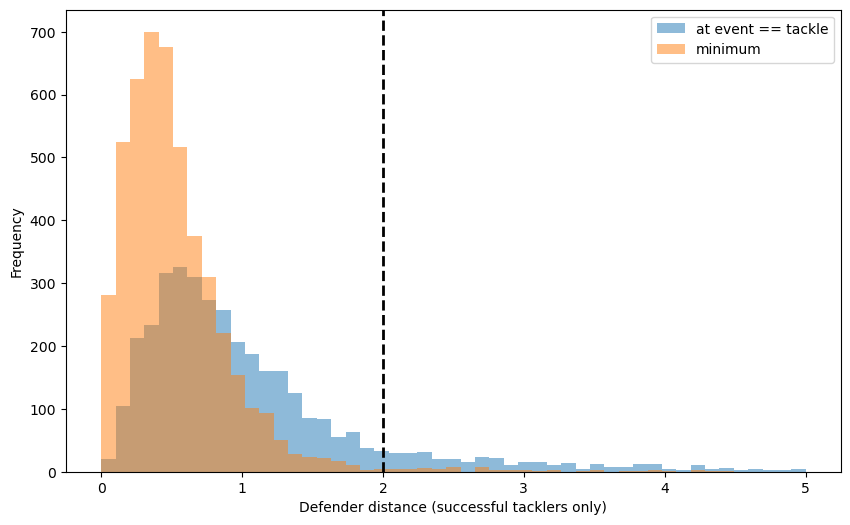

In [39]:
plt.figure(figsize=(10, 6))
hkw = dict(bins=np.linspace(0, 5, 50), alpha=0.5)
defenders.query("tackle == 1 & event == 'tackle'").dist_to_carrier.plot.hist(**hkw, label="at event == tackle")
defenders.query("tackle == 1").groupby(["gameId", "playId"]).dist_to_carrier.min().plot.hist(**hkw, label="minimum")
plt.axvline(x=2,linewidth = 2, linestyle ="--", 
            color ='black')
plt.xlabel("Defender distance (successful tacklers only)")
plt.legend(loc="upper right")
plt.show()

In [19]:
class TackleFeatures:
    WEIGHT_NORM = 250 # Scale by approximate mean player weight to keep values sensible
    FWIDTH = 53.3
    PLAYDEF = ["gameId", "playId", "nflId_defender"]
    
    @classmethod
    def relative_angle(cls, theta_carrier, theta_defender):
        theta_rel = theta_defender - theta_carrier
        return np.where(
            theta_rel.between(-180, 180),
            np.abs(theta_rel),
            360 - np.abs(theta_rel)
        ) / 180

    @classmethod
    def add_tackle_features(cls, defenders):
        existing_features = ['s_carrier','hull_area_defense','hull_area_offense','s_downfield','dist_to_carrier']
        
        dir_rel = cls.relative_angle(defenders.dir_carrier, defenders.dir_defender)

        defenders["o_rel"] = cls.relative_angle(defenders.o_carrier, defenders.o_defender)

        # Frames appear to be about 1ms apart, so just use that to avoid datetime nonsense
        defenders["time_since_receipt"] = 0.1 * (defenders.frameId - defenders.startFrameId)

        defenders["sideline_dist"] = np.minimum(
            defenders.y_carrier, cls.FWIDTH - defenders.y_carrier
        ) / cls.FWIDTH * 2

        #defenders["is_caught_pass"] = (defenders.receiptEvent == "pass_outcome_caught").astype("int")

        #defenders["is_qb"] = (defenders.position_carrier == "QB").astype("int")

        #defenders["congestion"] = np.where((defenders['hull_area_defense']<5)|(defenders['hull_area_offense']<5),1,0)

        new_f_idx = defenders.columns.get_loc("o_rel")
        return existing_features + defenders.columns.tolist()[new_f_idx:]

    @classmethod
    def extract_tackle_opps(cls, defenders, tackle_dist=2):
        # Extract all defenders get closer enough to the defender to potentially
        # make a tackle
        dsorted = defenders[
            (defenders.dist_to_carrier <= tackle_dist) &
            defenders[["tackle", "assist", "pff_missedTackle"]].any(axis=1)
        ].sort_values(
            cls.PLAYDEF + ["frameId"]
        ).reset_index(drop=True)

        # A bit of trickery to assign a "tackle opportunity index" = tidx to each carrier/defender interaction.
        # Note that, in some cases, there can be multiple such events in the same play if
        # the defender gets father and then closer. We will detect this via
        # "skips" in frames (as we've already focused only on frames where the two are close)
        dsorted["tidx"] = (
            dsorted[cls.PLAYDEF].diff().any(axis=1) |
            (dsorted.frameId.diff() != 1)
        ).cumsum()

        # We only care about the state at the beginning of each opportunity
        dsorted = dsorted.drop_duplicates("tidx", keep="first")

        # Assume tackles & assists only happen on the last opportunity
        final_opp_idx = dsorted.groupby(cls.PLAYDEF).tidx.max().rename("tidx_max")
        dsorted = dsorted.merge(final_opp_idx, left_on=cls.PLAYDEF, right_index=True)
        dsorted[["tackle", "assist"]] = dsorted[["tackle", "assist"]] * (
            dsorted.tidx_max == dsorted.tidx
        ).astype("int").values.reshape((-1, 1))
        # Drop resulting cases where we have an opp without a tackle as it has been reassigned
        dsorted = dsorted[
            dsorted[["tackle", "assist", "pff_missedTackle"]].any(axis=1)
        ].reset_index(drop=True)
        dsorted = dsorted.drop(columns=["tidx_max"])
        # If there's a tackle or assist in the opportunity, we'll say there's not a miss
        dsorted.pff_missedTackle = dsorted.pff_missedTackle * (1 - dsorted[["tackle", "assist"]].sum(axis=1))
        # Note: could also condition missed tackles must come before tackles?

        # Compute weights
        weights = 1 / dsorted.groupby(cls.PLAYDEF).pff_missedTackle.sum().rename("weight")
        weights = weights.fillna(1)
        dsorted = dsorted.merge(
            weights, left_on=cls.PLAYDEF, right_index=True
        )
        dsorted.weight = np.where(
            dsorted.pff_missedTackle == 1,
            dsorted.weight,
            1
        )
        
        tackle_features = cls.add_tackle_features(dsorted)
        return dsorted, tackle_features

In [20]:
defenders['position_carrier'] = defenders['nflId_carrier'].map(dict(zip(players_df['nflId'],players_df['position'])))

In [21]:
tackle_opps, tackle_features = TackleFeatures.extract_tackle_opps(defenders)


In [22]:
tackle_features = [x for x in tackle_features if x not in ['tidx','weight']]

In [23]:
tackle_df = pd.read_csv(Path(data_dir, "tackles.csv"))
nopps = tackle_opps.groupby(["gameId", "playId", "nflId_defender"]).tidx.nunique().rename("tackle_opportunities")
tackle_df = tackle_df.merge(
    nopps, 
    how="left", 
    left_on=["gameId", "playId", "nflId"], 
    right_index=True
)
tackle_df.tackle_opportunities = tackle_df.tackle_opportunities.fillna(0).astype("int")

In [24]:
tackle_df.tackle_opportunities = tackle_df.tackle_opportunities.fillna(0).astype("int")


In [25]:
tackle_df[tackle_df.tackle_opportunities > 0][
    ["tackle_opportunities", "tackle", "assist", "pff_missedTackle"]
].value_counts(normalize=True).sort_index()

tackle_opportunities  tackle  assist  pff_missedTackle
1                     0       0       1                   0.096942
                              1       0                   0.208742
                                      1                   0.001731
                      1       0       0                   0.680323
                                      1                   0.001443
2                     0       0       1                   0.008078
                              1       1                   0.001154
                      1       0       1                   0.001154
3                     0       0       1                   0.000289
4                     0       0       1                   0.000144
Name: proportion, dtype: float64

In [26]:
tackle_opps["outcome"] = np.where(
    tackle_opps.tackle == 1,
    "tackle",
    np.where(
        tackle_opps.assist == 1,
        "tackle assist",
        "miss"
    )
)

In [138]:
defenders.columns

Index(['gameId', 'playId', 'nflId_carrier', 'displayName_carrier', 'frameId',
       'time', 'jerseyNumber_carrier', 'club_carrier', 'playDirection',
       'x_carrier', 'y_carrier', 's_carrier', 'a_carrier', 'dis_carrier',
       'o_carrier', 'dir_carrier', 'event', 'ballCarrierId', 'startFrameId',
       'receiptEvent', 'endFrameId', 'endEvent', 'x_final', 's_downfield',
       'nflId_defender', 'displayName_defender', 'jerseyNumber_defender',
       'club_defender', 'x_defender', 'y_defender', 's_defender', 'a_defender',
       'dis_defender', 'o_defender', 'dir_defender', 'dist_to_carrier',
       'hull_area_offense', 'hull_area_defense', 'tackle', 'assist',
       'forcedFumble', 'pff_missedTackle', 'position_carrier', 'o_rel',
       'tackle_opp'],
      dtype='object')

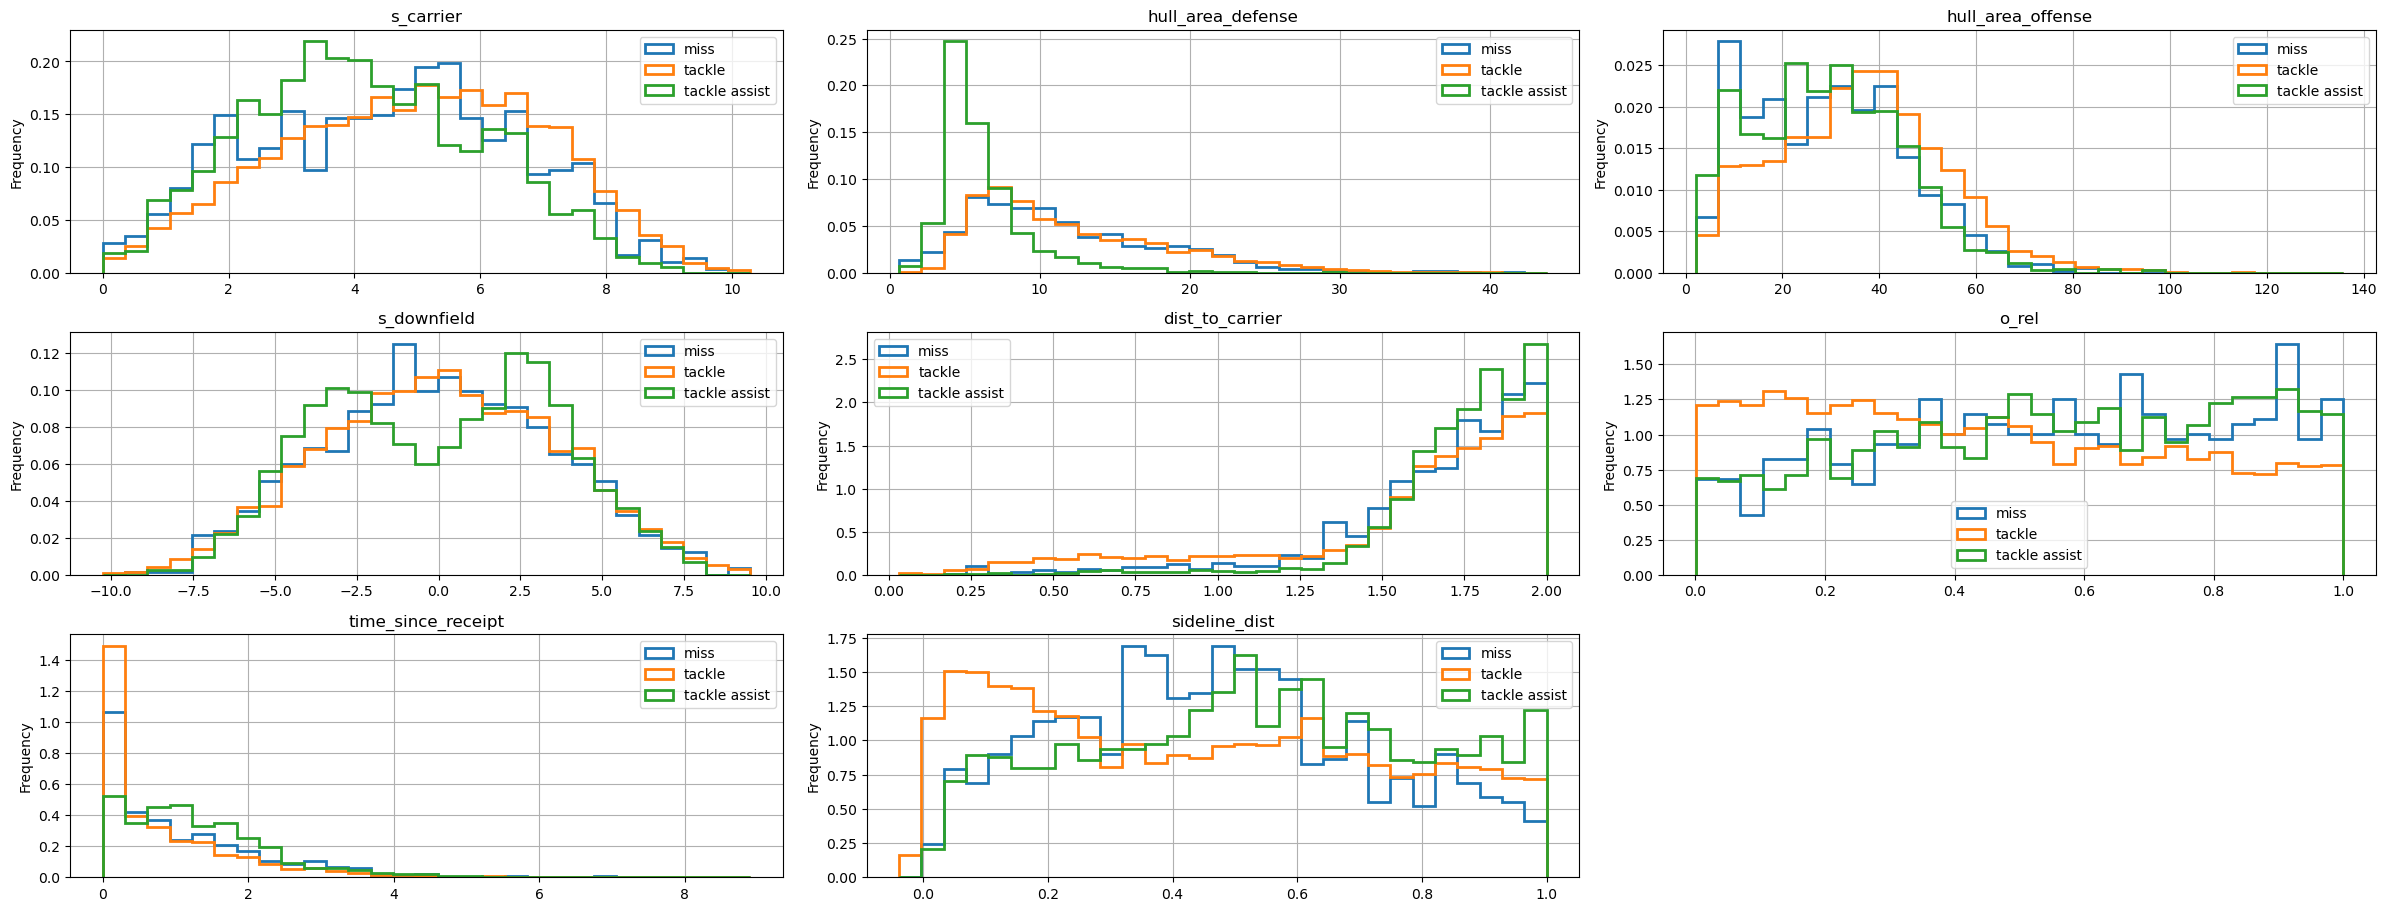

In [27]:
hkw = dict(histtype="step", density=True, lw=2)
maxbins = 30
fig = plt.figure(figsize=(24, 12))
for i, fn in enumerate(tackle_features):
    ax = fig.add_subplot(4, 3, i+1)
    if tackle_opps[fn].nunique() == 2:
        hbins = 2
    elif tackle_opps[fn].nunique() < maxbins:
        hbins = np.arange(tackle_opps[fn].min(), tackle_opps[fn].max()+1)
    else:
        hbins = np.linspace(tackle_opps[fn].min(), tackle_opps[fn].max(), maxbins)
    tackle_opps.groupby("outcome")[fn].plot.hist(
        ax=ax, bins=hbins, **hkw
    )
    ax.legend(loc="best")
    ax.set_title(fn)
    ax.grid()
plt.tight_layout()
plt.show()

# Models

In [28]:
tackle_opps.dropna(subset='hull_area_offense',inplace=True)

In [29]:
w = (1 - tackle_opps.assist) * tackle_opps.weight
y = tackle_opps[["tackle", "assist"]].sum(axis=1)
X = tackle_opps[tackle_features]

In [30]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [31]:
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(X, y, w, random_state=42, test_size=0.2)


In [32]:
p = {
      'objective':'binary:logistic',
      'eta':0.76,
      'reg_lambda':2.12,
      'scale_pos_weight':0.92,
    }

In [139]:
tackle_features

['s_carrier',
 'hull_area_defense',
 'hull_area_offense',
 's_downfield',
 'dist_to_carrier',
 'o_rel',
 'time_since_receipt',
 'sideline_dist']

In [33]:
tackle_models = dict(
    linear=LogisticRegression(),
    tree=XGBClassifier(**p,learning_rate = .05,max_depth=10,n_estimators=50)
)

for name, model in tackle_models.items():
    print(f"### model = {name} ###")
    _tackle_model = model.fit(X_train, y_train, sample_weight=w_train)

    train_acc = _tackle_model.score(X_train, y_train, w_train)
    ptr = _tackle_model.predict_proba(X_train)[:,1]
    train_f1 = f1_score(y_train, (ptr > 0.5).astype("int"), sample_weight=w_train,
                                                 zero_division=np.nan)
    train_roc = roc_auc_score(y_train, ptr, sample_weight=w_train)
    train_brier = brier_score_loss(y_train, ptr, sample_weight=w_train)
    print(f"train: acc = {train_acc:.4f}, f1 = {train_f1:.4f}, roc auc = {train_roc:.4f},brier_score = {train_brier:.4f}")

    test_acc = _tackle_model.score(X_test, y_test, w_test)
    pte = _tackle_model.predict_proba(X_test)[:,1]
    test_f1 = f1_score(y_test, (pte > 0.5).astype("int"), sample_weight=w_test,
                                             zero_division=np.nan)
    test_roc = roc_auc_score(y_test, pte, sample_weight=w_test)
    test_brier = brier_score_loss(y_test, pte, sample_weight=w_test)
    print(f"test: acc = {test_acc:.4f}, f1 = {test_f1:.4f}, roc auc = {test_roc:.4f},brier_score = {test_brier:.4f}")

### model = linear ###
train: acc = 0.8652, f1 = 0.9277, roc auc = 0.6525,brier_score = 0.1129
test: acc = 0.8582, f1 = 0.9237, roc auc = 0.6388,brier_score = 0.1188
### model = tree ###
train: acc = 0.8921, f1 = 0.9413, roc auc = 0.9850,brier_score = 0.0634
test: acc = 0.8605, f1 = 0.9244, roc auc = 0.6617,brier_score = 0.1166


In [34]:
explainer = shap.TreeExplainer(tackle_models['tree'])
shap_values = explainer.shap_values(X_test)

In [ ]:
['s_carrier',
 'hull_area_defense',
 'hull_area_offense',
 's_downfield',
 'dist_to_carrier',
 'o_rel',
 'time_since_receipt',
 'sideline_dist']

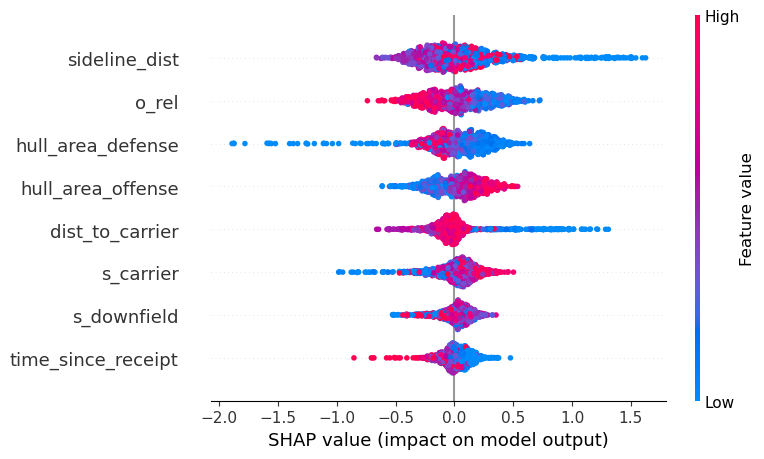

In [35]:
shap.summary_plot(shap_values, X_test,feature_names=['Speed carrier', 'Hull area defense','Hull area offense','Speed downfield','Distance to carrier','Relative Angle',
                                                     'Time since receipt','Sideline distance'])

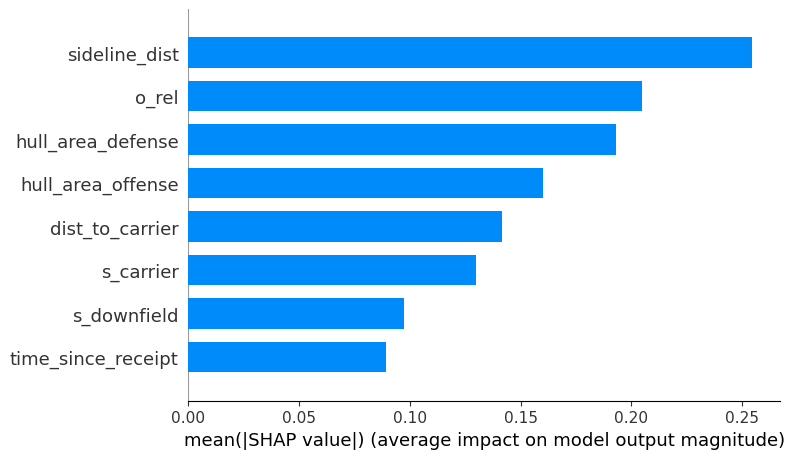

In [36]:
shap.summary_plot(shap_values, X_test,feature_names=['Speed carrier', 'Hull area defense','Hull area offense','Speed downfield','Distance to carrier','Relative Angle',
                                                     'Time since receipt','Sideline distance'],plot_type='bar')

## Metric 1: Tackles Above Replacement (TAR)

To quantify "tackle difficulty," we introduce a metric we call  "Tackles Above Replacement" (TAR), defined as
\begin{align}
TAR & = \sum_{tackles} 1 - p_\theta(\text{tackle} | \text{context})
\end{align}
where $p_\theta$ represents our model that tells us "given the context of the tackle (attempt), how likely is it that the defender made the tackle?" I.e., an impossible tackle should have $p_\theta = 0$, such that when a defender makes such a tackle the contribution to TAR is 1. Conversely, a trivial tackle (with $p_\theta = 1$) does not increase TAR at all.

One obvious shortcoming of such a metric, though, is that it doesn't take into account missed tackles. For this, we consider a modification TAR+ defined as
\begin{align}
TAR+ & = \sum_{tackles} (1 - p_\theta) - \sum_{misses} p_\theta
\end{align}
TAR+ penalizes players for missing tackles, again proportional to the difficulty of the tackle; tackles that were easy to make ($p_\theta = 1$) carry large penalties, while tackles that were hard carry negligible penalties. Note that this is still not a perfect metric as players can avoid be penalized at all by, e.g., not attempting tackles. One way to address this would be by defining a metric over all opportunities 

In [37]:
tackle_model = tackle_models["tree"]
p_tackle = tackle_model.predict_proba(
    StandardScaler().fit_transform(tackle_opps[tackle_features])
)[:,1]
tackle_opps["p_tackle"] = p_tackle
tackle_opps["TAR"] = tackle_opps.tackle * (1 - p_tackle)
tackle_opps["TAR+"] = tackle_opps.TAR - tackle_opps.pff_missedTackle * p_tackle * tackle_opps.weight
tackle_opps["missed"] = tackle_opps.pff_missedTackle * tackle_opps.weight

In [38]:
player_tar_df = tackle_opps.groupby(
    ["displayName_defender", "nflId_defender"]
)[["tackle", "missed", "TAR", "TAR+"]].sum()

In [39]:
player_tar_df.sort_values('TAR+')

,,tackle,missed,TAR,TAR+
displayName_defender,nflId_defender,,,,
Darious Williams,46456,9,7.0,1.050079,-4.053082
Jaelan Phillips,53447,1,5.0,0.055511,-3.679238
Deommodore Lenoir,53601,13,5.0,0.929397,-3.157085
Kristian Fulton,52469,15,7.0,1.593035,-2.662589
Damarri Mathis,54580,19,5.0,1.373162,-2.585320
...,...,...,...,...,...
Carlton Davis,46132,24,1.0,3.055012,2.302537
Tremaine Edmunds,46085,22,1.0,2.976737,2.400644
Kamu Grugier-Hill,43497,17,0.0,2.408533,2.408533


In [40]:
tackle_opps[(tackle_opps['gameId'].isin(week_1['gameId'].unique()))&
            (tackle_opps['outcome']=='tackle')].sort_values('p_tackle')[['gameId', 'playId', 'displayName_carrier','displayName_defender', 'frameId',
                                                                                           'tackle','weight', 'assist','p_tackle', 'TAR', 'TAR+', 'missed','outcome']]

,gameId,playId,displayName_carrier,displayName_defender,frameId,tackle,weight,assist,p_tackle,TAR,TAR+,missed,outcome
63,2022091100,458,Olamide Zaccheaus,Marcus Maye,32,1,1.0,0,0.592948,0.407052,0.407052,0.0,tackle
487,2022091108,1132,Dontrell Hilliard,Adoree' Jackson,8,1,1.0,0,0.604119,0.395881,0.395881,0.0,tackle
325,2022091105,3387,Ashton Dulin,Steven Nelson,6,1,1.0,0,0.608934,0.391066,0.391066,0.0,tackle
792,2022091200,664,Rashaad Penny,Kareem Jackson,41,1,1.0,0,0.616118,0.383882,0.383882,0.0,tackle
28,2022090800,1836,Cooper Kupp,Von Miller,27,1,1.0,0,0.644573,0.355427,0.355427,0.0,tackle
...,...,...,...,...,...,...,...,...,...,...,...,...,...
314,2022091105,2637,Rex Burkhead,Nick Cross,18,1,1.0,0,0.974437,0.025563,0.025563,0.0,tackle
819,2022091200,2009,Courtland Sutton,Josh Jones,10,1,1.0,0,0.974540,0.025460,0.025460,0.0,tackle
348,2022091106,196,Hunter Henry,Xavien Howard,10,1,1.0,0,0.974670,0.025330,0.025330,0.0,tackle
444,2022091107,2803,Elijah Moore,Marlon Humphrey,15,1,1.0,0,0.974983,0.025017,0.025017,0.0,tackle


In [41]:
animate_play(games_df,week_1,play_df,players_df,2022090800,56,hull=True)

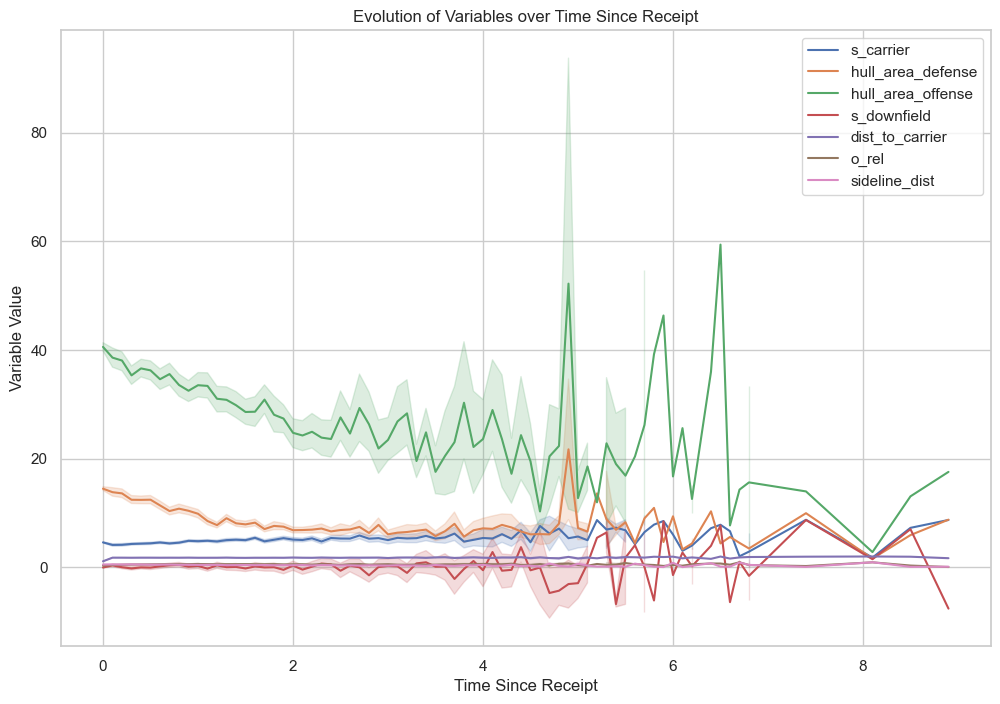

In [42]:
# Set the style for the plots
sns.set(style="whitegrid")

# Create a figure and axis
plt.figure(figsize=(12, 8))

# Plot the variables against time_since_receipt
sns.lineplot(x='time_since_receipt', y='s_carrier', data=tackle_opps, label='s_carrier')
sns.lineplot(x='time_since_receipt', y='hull_area_defense', data=tackle_opps, label='hull_area_defense')
sns.lineplot(x='time_since_receipt', y='hull_area_offense', data=tackle_opps, label='hull_area_offense')
sns.lineplot(x='time_since_receipt', y='s_downfield', data=tackle_opps, label='s_downfield')
sns.lineplot(x='time_since_receipt', y='dist_to_carrier', data=tackle_opps, label='dist_to_carrier')
sns.lineplot(x='time_since_receipt', y='o_rel', data=tackle_opps, label='o_rel')
sns.lineplot(x='time_since_receipt', y='sideline_dist', data=tackle_opps, label='sideline_dist')

# Set labels and title
plt.xlabel('Time Since Receipt')
plt.ylabel('Variable Value')
plt.title('Evolution of Variables over Time Since Receipt')

# Show the legend
plt.legend()

# Show the plot
plt.show()

In [43]:
## Jugada de pase
## Tomar en cuenta orientacion del defensivo vs el carrier, velocidad hacia el carrier, congestion en la zona?, es el mas cercano al balon?

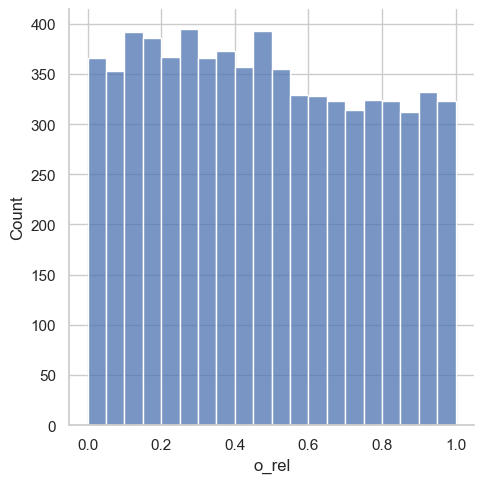

In [44]:
sns.displot(tackle_opps['o_rel'])

In [45]:
def relative_angle(theta_carrier, theta_defender):
    theta_rel = theta_defender - theta_carrier
    return np.where(
        theta_rel.between(-180, 180),
        np.abs(theta_rel),
        360 - np.abs(theta_rel)
    ) / 180


defenders["o_rel"] = relative_angle(defenders.o_carrier, defenders.o_defender)

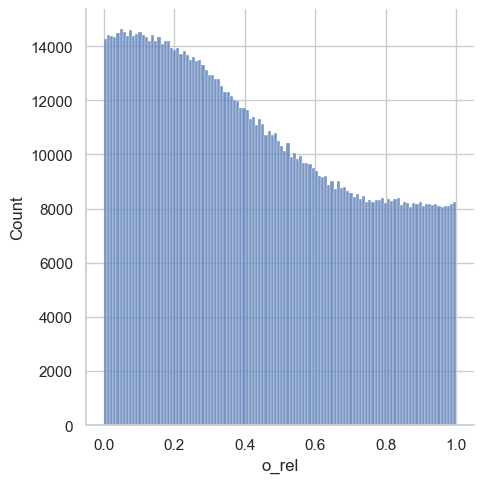

In [46]:
sns.displot(defenders['o_rel'])

In [47]:
defenders = defenders.merge(tackle_opps.groupby(['gameId', 'playId','frameId','nflId_carrier','nflId_defender'],as_index=False).size().rename({'size':'tackle_opp'},axis=1),
                how='left')

In [48]:
defenders['tackle_opp'].value_counts(dropna=False)

tackle_opp
NaN    1215760
1.0       7011
Name: count, dtype: int64

In [49]:
def get_3_closest_defenders(group):
    group = group.sort_values('dist_to_carrier')
    return group.iloc[:3]

In [50]:
grouped_defenders = defenders.groupby(['gameId', 'playId','frameId'])

In [51]:
closest_3_defenders = grouped_defenders.apply(get_3_closest_defenders)

In [52]:
closest_3_defenders['tackle_opp'].value_counts(dropna=False)

tackle_opp
NaN    326515
1.0      6968
Name: count, dtype: int64

In [53]:
closest_3_defenders = closest_3_defenders.reset_index(drop=True)

In [54]:
closest_3_defenders['tackle_opp'].fillna(0,inplace=True)

In [55]:
closest_3_defenders["time_since_receipt"] = 0.1 * (closest_3_defenders.frameId - closest_3_defenders.startFrameId)

In [56]:
closest_3_defenders[['hull_area_defense',
 'hull_area_offense',]]

,hull_area_defense,hull_area_offense
0,9.477805,31.522897
1,9.477805,31.522897
2,9.477805,31.522897
3,8.924803,31.693144
4,8.924803,31.693144
...,...,...
333478,34.149649,40.642287
333479,34.149649,40.642287
333480,34.126023,41.052727
333481,34.126023,41.052727


In [57]:
closest_3_defenders.groupby('tackle_opp')[['time_since_receipt','dist_to_carrier','o_rel','s_downfield']].describe().T

tackle_opp                          0.0          1.0
time_since_receipt count  326515.000000  6968.000000
                   mean        1.346506     0.926952
                   std         1.171776     1.019991
                   min         0.000000     0.000000
                   25%         0.500000     0.000000
                   50%         1.100000     0.600000
                   75%         1.900000     1.400000
                   max        10.800000     8.900000
dist_to_carrier    count  326515.000000  6968.000000
                   mean        4.876663     1.597304
                   std         4.318888     0.405962
                   min         0.000000     0.031623
                   25%         1.370839     1.520428
                   50%         3.670817     1.726992
                   75%         7.169794     1.873072
                   max        49.590065     1.999850
o_rel              count  326515.000000  6968.000000
                   mean        0.453471     0.481987
                   std         0.289333     0.286770
                   min         0.000000     0.000222
                   25%         0.200333     0.234319
                   50%         0.423667     0.469806
                   75%         0.698500     0.727542
                   max         1.000000     0.999889
s_downfield        count  326515.000000  6968.000000
                   mean        0.083798     0.048101
                   std         3.594394     3.518911
                   min       -10.296245   -10.262234
                   25%        -2.483856    -2.606884
                   50%         0.078315     0.073681
                   75%         2.659856     2.708449
                   max        10.071131     9.519614

In [58]:
tackle_opps.groupby('displayName_defender')['time_since_receipt'].mean().sort_values()

displayName_defender
Marcell Harris      0.0
Daxton Hill         0.0
Carlos Dunlap       0.0
Christian Holmes    0.0
Jamir Jones         0.0
                   ... 
Deon Bush           3.9
Myles Adams         4.1
Sam Okuayinonu      4.3
Carl Granderson     6.0
Michael Dwumfour    6.7
Name: time_since_receipt, Length: 632, dtype: float64

In [59]:
tackle_opps.corr(numeric_only=True)['TAR'].sort_values()

assist                  -0.494792
pff_missedTackle        -0.347641
missed                  -0.339914
endFrameId              -0.119851
hull_area_offense       -0.071461
x_final                 -0.057557
o_carrier               -0.044445
p_tackle                -0.041130
x_carrier               -0.037749
nflId_defender          -0.035500
x_defender              -0.033336
dis_defender            -0.029696
s_defender              -0.026073
time_since_receipt      -0.024179
frameId                 -0.023320
jerseyNumber_carrier    -0.022642
dir_carrier             -0.016544
playId                  -0.011179
tidx                    -0.007518
gameId                  -0.005971
nflId_carrier           -0.005564
ballCarrierId           -0.005564
jerseyNumber_defender   -0.002040
startFrameId             0.001902
s_downfield              0.007171
sideline_dist            0.012151
a_defender               0.014009
s_carrier                0.014722
dis_carrier              0.014864
y_defender    

In [60]:
closest_3_defenders

,gameId,playId,nflId_carrier,displayName_carrier,frameId,time,jerseyNumber_carrier,club_carrier,playDirection,x_carrier,...,hull_area_offense,hull_area_defense,tackle,assist,forcedFumble,pff_missedTackle,position_carrier,o_rel,tackle_opp,time_since_receipt
0,2022090800,56,42489,Stefon Diggs,6,2022-09-08 20:24:05.700000,14,BUF,left,40.15,...,31.522897,9.477805,1,0,0,0,WR,0.148278,0.0,0.0
1,2022090800,56,42489,Stefon Diggs,6,2022-09-08 20:24:05.700000,14,BUF,left,40.15,...,31.522897,9.477805,0,0,0,0,WR,0.057278,0.0,0.0
2,2022090800,56,42489,Stefon Diggs,6,2022-09-08 20:24:05.700000,14,BUF,left,40.15,...,31.522897,9.477805,0,0,0,0,WR,0.693333,0.0,0.0
3,2022090800,56,42489,Stefon Diggs,7,2022-09-08 20:24:05.799999,14,BUF,left,40.31,...,31.693144,8.924803,1,0,0,0,WR,0.168833,0.0,0.1
4,2022090800,56,42489,Stefon Diggs,7,2022-09-08 20:24:05.799999,14,BUF,left,40.31,...,31.693144,8.924803,0,0,0,0,WR,0.074556,0.0,0.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
333478,2022110700,3480,52942,Juwan Johnson,54,2022-11-07 22:52:13.200000,83,NO,right,109.13,...,40.642287,34.149649,0,0,0,0,TE,0.576111,0.0,4.8
333479,2022110700,3480,52942,Juwan Johnson,54,2022-11-07 22:52:13.200000,83,NO,right,109.13,...,40.642287,34.149649,0,0,0,0,TE,0.782278,0.0,4.8
333480,2022110700,3480,52942,Juwan Johnson,55,2022-11-07 22:52:13.299999,83,NO,right,109.82,...,41.052727,34.126023,0,0,0,0,TE,0.368444,0.0,4.9
333481,2022110700,3480,52942,Juwan Johnson,55,2022-11-07 22:52:13.299999,83,NO,right,109.82,...,41.052727,34.126023,0,0,0,0,TE,0.551222,0.0,4.9


In [61]:
ttt_df = defenders.copy()

In [62]:
ttt_df.columns

Index(['gameId', 'playId', 'nflId_carrier', 'displayName_carrier', 'frameId',
       'time', 'jerseyNumber_carrier', 'club_carrier', 'playDirection',
       'x_carrier', 'y_carrier', 's_carrier', 'a_carrier', 'dis_carrier',
       'o_carrier', 'dir_carrier', 'event', 'ballCarrierId', 'startFrameId',
       'receiptEvent', 'endFrameId', 'endEvent', 'x_final', 's_downfield',
       'nflId_defender', 'displayName_defender', 'jerseyNumber_defender',
       'club_defender', 'x_defender', 'y_defender', 's_defender', 'a_defender',
       'dis_defender', 'o_defender', 'dir_defender', 'dist_to_carrier',
       'hull_area_offense', 'hull_area_defense', 'tackle', 'assist',
       'forcedFumble', 'pff_missedTackle', 'position_carrier', 'o_rel',
       'tackle_opp'],
      dtype='object')

In [63]:
ttt_df['any_tackle_opp'] = ttt_df[['tackle', 'assist','forcedFumble', 'pff_missedTackle']].sum(axis=1)

In [64]:
ttt_df = ttt_df[ttt_df['any_tackle_opp']>=1]

In [65]:
ttt_df["time_since_receipt"] = 0.1 * (ttt_df.frameId - ttt_df.startFrameId)

In [66]:
# Identify the frameId where tackle_opp is equal to 1 for each group
tackle_opp_frame = ttt_df[ttt_df['tackle_opp'] == 1].groupby(['gameId', 'playId'])['frameId'].min().reset_index()

# Merge the original DataFrame with the identified tackle_opp frameId
df_merged = pd.merge(ttt_df, tackle_opp_frame, on=['gameId', 'playId'], suffixes=('', '_tackle_opp'))

# Keep only the rows where frameId is less than the tackle_opp frameId
result_df = df_merged[df_merged['frameId'] <= df_merged['frameId_tackle_opp']]

# Drop the additional columns used for merging if needed
ttt_df = result_df.drop(columns=['frameId_tackle_opp'])

In [67]:
ttt_df = ttt_df.merge(ttt_df.groupby(['gameId','playId'],as_index=False)['time_since_receipt'].max(),
             on=['gameId','playId'],suffixes=('', '_max'))

In [68]:
ttt_df['time_to_tackle'] = ttt_df['time_since_receipt_max'] - ttt_df['time_since_receipt']

In [69]:
ttt_df['tackle_opp'].fillna(0,inplace=True)

In [70]:
ttt_features = [
 'hull_area_offense',
 'hull_area_defense',
 'dist_to_carrier',
 's_defender',
 's_carrier',
 'o_rel']

In [71]:
FWIDTH = 53.3
ttt_df["sideline_dist"] = np.minimum(
            ttt_df.y_carrier, FWIDTH- ttt_df.y_carrier
        ) / FWIDTH * 2

In [72]:
X = StandardScaler().fit_transform(ttt_df[ttt_features])
y = ttt_df['time_to_tackle'].values

In [73]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

In [74]:
def objective(trial):
    params = {
        'objective': 'reg:squarederror',
        'booster': 'gbtree',
        'eval_metric': 'rmse',
        'tree_method': 'auto',
        'n_jobs': -1,
        'verbosity': 0,
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0.0, 1.0),
    }

    model = XGBRegressor(**params, random_state=42)
    model.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=10, verbose=False)
    predictions = model.predict(X_test)
    rmse = mean_squared_error(y_test, predictions,squared=False)

    return rmse

In [75]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100, n_jobs=-1)

# Print the best hyperparameters and their corresponding value
print('Best trial:')
trial = study.best_trial
print('  Value: {}'.format(trial.value))
print('  Params: ')
for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

[I 2024-01-06 13:30:31,157] A new study created in memory with name: no-name-a1bf0367-a4cf-4fcf-8ea8-a31892ee4b9d
[I 2024-01-06 13:30:32,580] Trial 5 finished with value: 0.5025760971392369 and parameters: {'learning_rate': 0.1780804823621803, 'n_estimators': 167, 'max_depth': 3, 'min_child_weight': 4, 'subsample': 0.9897764881760627, 'colsample_bytree': 0.7913317155942623, 'gamma': 0.8983609857490706}. Best is trial 5 with value: 0.5025760971392369.
[I 2024-01-06 13:30:33,081] Trial 1 finished with value: 0.4408351982279229 and parameters: {'learning_rate': 0.1607949793754376, 'n_estimators': 724, 'max_depth': 9, 'min_child_weight': 1, 'subsample': 0.7060765237929174, 'colsample_bytree': 0.8534546493281463, 'gamma': 0.8791313224184575}. Best is trial 1 with value: 0.4408351982279229.
[I 2024-01-06 13:30:33,485] Trial 9 finished with value: 0.44531266405186787 and parameters: {'learning_rate': 0.2571870798870284, 'n_estimators': 388, 'max_depth': 9, 'min_child_weight': 6, 'subsample': 

Best trial:
  Value: 0.3889220602795581
  Params: 
    learning_rate: 0.08136369979201916
    n_estimators: 901
    max_depth: 10
    min_child_weight: 2
    subsample: 0.919135031179299
    colsample_bytree: 0.8887124994340392
    gamma: 0.0038890536057787084


In [76]:
regression_model = XGBRegressor(**trial.params)

In [77]:
regression_model.fit(X_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8887124994340392, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0.0038890536057787084,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.08136369979201916,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=2, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=901, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [141]:
mean_squared_error(regression_model.predict(X_test),y_test,squared=False)

0.388628824121542

In [79]:
regression_model.score(X_test,y_test)

0.7250362151058988

In [80]:
ttt_df['predicted_time'] = regression_model.predict(StandardScaler().fit_transform(ttt_df[ttt_features]))

In [81]:
#ttt_df['predicted_time'] = np.where(ttt_df['predicted_time']<0,0,ttt_df['predicted_time'])

<Axes: xlabel='frameId', ylabel='time_to_tackle'>

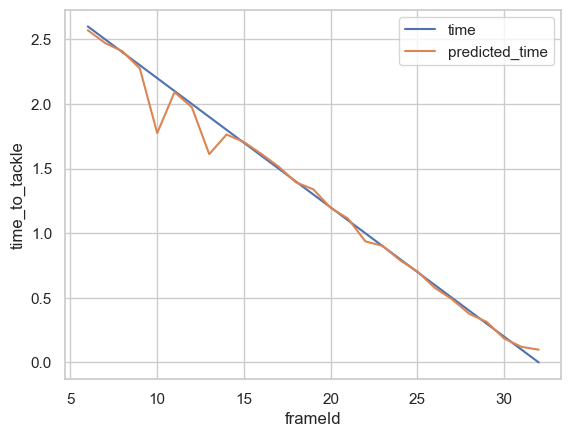

In [82]:
vis_df = ttt_df[(ttt_df['gameId']==2022110700)&(ttt_df['playId']==3429)]
sns.lineplot(x='frameId',y='time_to_tackle', data=vis_df, label='time')
sns.lineplot(x='frameId',y='predicted_time', data=vis_df, label='predicted_time')

In [83]:
ttt_df['predicted_time_diff'] = np.abs(ttt_df.groupby(['gameId','playId'])['predicted_time'].diff())

In [84]:
ttt_df['predicted_time_diff'].fillna(ttt_df['predicted_time'],inplace=True)

In [85]:
ttt_df['TtTOE'] = ttt_df['time_to_tackle']-ttt_df['predicted_time']

In [86]:
games_player = ttt_df[['displayName_defender','gameId','playId']].drop_duplicates()
games_player['play'] = 1 

In [87]:
games_player = games_player.groupby('displayName_defender',as_index=False)['play'].sum()

In [88]:
tackle_time = ttt_df.groupby(["displayName_defender", "nflId_defender"],as_index=False
)['TtTOE'].agg({'sum'})

In [89]:
tackle_time = tackle_time.merge(games_player)

In [90]:
tackle_time = tackle_time[tackle_time['play']>10].sort_values('sum')

In [91]:
metrics_df = tackle_time.merge(player_tar_df.reset_index())

In [92]:
metrics_df = metrics_df.rename({'sum':'TtTOE'},axis=1)

In [93]:
metrics_df['TtTOE per play'] =metrics_df['TtTOE']/metrics_df['play']

In [94]:
minmax = MinMaxScaler()

In [95]:
metrics_df['TtTOE scaled'] = pd.qcut(metrics_df['TtTOE'],q=100,labels=False)
metrics_df['TAR+ scaled'] = pd.qcut(metrics_df['TAR+'],q=100,labels=False)

In [96]:
metrics_df['TAR + TtTOE'] =(.5*metrics_df['TtTOE scaled'])+(.5*metrics_df['TAR+ scaled'])
metrics_df['Diff'] = np.abs(metrics_df['TtTOE scaled'] - metrics_df['TAR+ scaled'])

In [97]:
metrics_df.sort_values('TAR + TtTOE',ascending=False).head(20).style.background_gradient(subset=['TtTOE','TAR+','TAR + TtTOE',
                                                                                                'Diff'])

,displayName_defender,nflId_defender,TtTOE,play,tackle,missed,TAR,TAR+,TtTOE per play,TtTOE scaled,TAR+ scaled,TAR + TtTOE,Diff
256,Jordan Hicks,42427,12.169128,29,24,1.000000,2.457491,1.779409,0.419625,97,94,95.500000,3
234,Harrison Smith,38559,5.894098,32,28,1.000000,3.410961,2.543535,0.184191,89,99,94.000000,10
231,Tashaun Gipson,38868,5.178515,16,15,0.000000,1.987599,1.987599,0.323657,88,97,92.500000,9
239,Jalen Thompson,49410,6.590038,30,23,1.000000,2.312078,1.696493,0.219668,91,93,92.000000,2
223,Carlton Davis,46132,4.480447,27,24,1.000000,3.055012,2.302537,0.165942,85,98,91.500000,13
235,Andre Cisco,53494,6.098406,27,20,2.000000,2.860235,1.660800,0.225867,89,92,90.500000,3
244,Minkah Fitzpatrick,46080,7.326615,20,15,0.000000,1.450444,1.450444,0.366331,93,87,90.000000,6
260,Devin McCourty,35466,19.936203,25,18,1.000000,1.797539,1.202557,0.797448,99,80,89.500000,19
211,Bobby Wagner,38577,2.685812,24,19,0.000000,2.923015,2.923015,0.111909,80,99,89.500000,19
220,Jeff Okudah,52411,4.059308,22,20,0.000000,1.817297,1.817297,0.184514,83,95,89.000000,12


In [98]:
metrics_df.sort_values('TAR + TtTOE').head(20).style.background_gradient(subset=['TtTOE','TAR+','TAR + TtTOE'])

,displayName_defender,nflId_defender,TtTOE,play,tackle,missed,TAR,TAR+,TtTOE per play,TtTOE scaled,TAR+ scaled,TAR + TtTOE,Diff
15,Kristian Fulton,52469,-7.400571,29,15,7.000000,1.593035,-2.662589,-0.255192,5,0,2.500000,5
10,Elandon Roberts,43503,-7.972580,19,9,5.000000,0.838815,-2.089726,-0.419609,3,3,3.000000,0
12,Talanoa Hufanga,53609,-7.662516,20,11,6.000000,1.312850,-1.897834,-0.383126,4,4,4.000000,0
5,A.J. Terrell,52424,-10.463553,24,13,4.000000,1.536251,-1.301457,-0.435981,1,9,5.000000,8
31,Brandon Jones,52478,-5.196232,32,13,5.000000,1.391588,-2.026765,-0.162382,11,4,7.500000,7
13,Jaylinn Hawkins,52542,-7.592853,37,21,5.000000,2.299527,-1.064481,-0.205212,4,11,7.500000,7
27,Shaq Thompson,42368,-5.375751,24,16,5.000000,1.658806,-1.893580,-0.223990,10,5,7.500000,5
43,Deommodore Lenoir,53601,-4.591802,27,13,5.000000,0.929397,-3.157085,-0.170067,16,0,8.000000,16
2,Juston Burris,43407,-11.527751,11,6,2.000000,0.833337,-0.587344,-1.047977,0,22,11.000000,22
44,Coby Bryant,54574,-4.560381,30,22,5.000000,2.346211,-1.473823,-0.152013,16,7,11.500000,9


<Axes: >

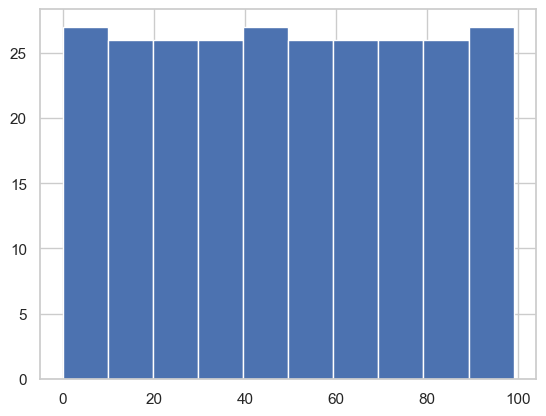

In [99]:
metrics_df['TtTOE scaled'].hist()

In [100]:
metrics_df[(metrics_df['TtTOE']>=-2)&(metrics_df['TtTOE']<=2)].style.background_gradient(subset=['TtTOE'])

,displayName_defender,nflId_defender,TtTOE,play,tackle,missed,TAR,TAR+,TtTOE per play,TtTOE scaled,TAR+ scaled,TAR + TtTOE,Diff
93,J.C. Jackson,46775,-1.961367,12,9,1.000000,0.921766,0.503235,-0.163447,35,58,46.500000,23
94,Jayon Brown,44968,-1.879070,12,11,0.000000,1.158280,1.158280,-0.156589,35,79,57.000000,44
95,Kamren Curl,52624,-1.864054,19,14,1.000000,1.361449,0.709388,-0.098108,36,62,49.000000,26
96,Willie Gay,52471,-1.838549,19,11,4.000000,1.131279,-1.415578,-0.096766,36,8,22.000000,28
97,Chidobe Awuzie,44872,-1.823968,25,20,3.000000,1.848682,-0.299024,-0.072959,37,31,34.000000,6
98,Darrick Forrest,53592,-1.808950,23,17,1.000000,1.474647,0.659783,-0.078650,37,62,49.500000,25
99,Damarri Mathis,54580,-1.807324,26,19,5.000000,1.373162,-2.585320,-0.069512,37,1,19.000000,36
100,Antonio Hamilton,43986,-1.797139,11,8,2.000000,0.447593,-0.953907,-0.163376,38,13,25.500000,25
101,Dylan Cole,45643,-1.764383,13,6,3.000000,0.674004,-1.207160,-0.135722,38,10,24.000000,28
102,Quay Walker,54487,-1.715952,20,14,3.000000,1.443686,-0.255451,-0.085798,38,32,35.000000,6


In [101]:
metrics_df.sort_values('Diff',ascending=False).head(20).round(3).style.background_gradient(subset=['TtTOE','TAR+','Diff'])

,displayName_defender,nflId_defender,TtTOE,play,tackle,missed,TAR,TAR+,TtTOE per play,TtTOE scaled,TAR+ scaled,TAR + TtTOE,Diff
255,Josh Jones,44873,11.978000,15,10,4.000000,0.793000,-2.185000,0.799000,97,2,49.500000,95
6,Marcus Williams,44854,-10.273000,25,20,1.000000,2.429000,1.845000,-0.411000,2,96,49.000000,94
251,Chauncey Gardner-Johnson,47888,9.726000,33,24,7.000000,2.206000,-1.844000,0.295000,95,5,50.000000,90
25,Tremaine Edmunds,46085,-5.721000,32,22,1.000000,2.977000,2.401000,-0.179000,9,98,53.500000,89
257,Devin Lloyd,54492,13.585000,38,20,5.000000,2.293000,-1.334000,0.357000,98,9,53.500000,89
8,Adrian Amos,42485,-9.002000,21,17,1.000000,2.217000,1.659000,-0.429000,3,91,47.000000,88
34,Kamu Grugier-Hill,43497,-4.891000,20,17,0.000000,2.409000,2.409000,-0.245000,12,99,55.500000,87
245,Budda Baker,44848,7.531000,29,16,5.000000,2.005000,-1.134000,0.260000,93,11,52.000000,82
39,Cameron Dantzler,52497,-4.741000,34,30,2.000000,2.985000,1.825000,-0.139000,14,95,54.500000,81
261,Taylor Rapp,47844,20.047000,27,15,3.000000,1.486000,-0.619000,0.742000,99,19,59.000000,80


In [102]:
explainer = shap.TreeExplainer(regression_model)
shap_values = explainer.shap_values(X_test)

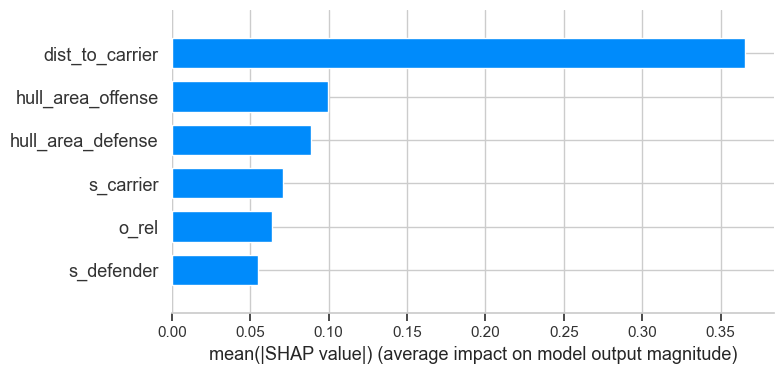

In [103]:
shap.summary_plot(shap_values, X_test,feature_names=ttt_features,plot_type='bar')

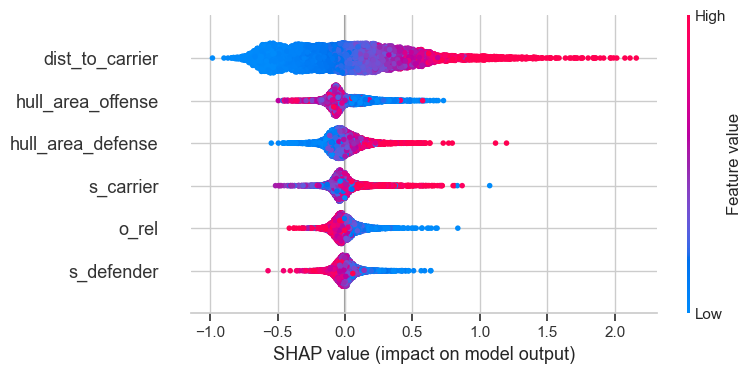

In [104]:
shap.summary_plot(shap_values, X_test,feature_names=ttt_features)

In [105]:
metrics_df.sort_values('TtTOE')

,displayName_defender,nflId_defender,TtTOE,play,tackle,missed,TAR,TAR+,TtTOE per play,TtTOE scaled,TAR+ scaled,TAR + TtTOE,Diff
0,David Long,47971,-14.297690,49,19,3.0,2.054648,-0.023589,-0.291790,0,40,20.0,40
1,Kareem Jackson,35459,-12.611148,25,16,3.0,2.182500,0.189586,-0.504446,0,46,23.0,46
2,Juston Burris,43407,-11.527751,11,6,2.0,0.833337,-0.587344,-1.047977,0,22,11.0,22
3,Mike Edwards,47882,-10.843556,34,20,3.0,1.890688,-0.100456,-0.318928,1,38,19.5,37
4,Eddie Jackson,44925,-10.580440,39,25,5.0,2.859141,-0.303686,-0.271293,1,31,16.0,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...
258,Zaire Franklin,46304,17.310764,43,24,4.0,3.131608,0.739309,0.402576,98,63,80.5,35
259,John Johnson,44903,19.333694,20,16,2.0,2.069840,0.834311,0.966685,98,67,82.5,31
260,Devin McCourty,35466,19.936203,25,18,1.0,1.797539,1.202557,0.797448,99,80,89.5,19
261,Taylor Rapp,47844,20.046826,27,15,3.0,1.485790,-0.618878,0.742475,99,19,59.0,80


<Axes: >

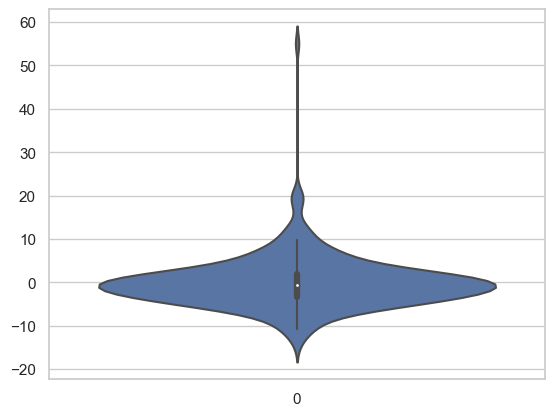

In [106]:
sns.violinplot(metrics_df['TtTOE'])

In [107]:
metrics_df['position'] = metrics_df['nflId_defender'].map(dict(zip(players_df['nflId'],players_df['position'])))
# Create quintiles for 'TtTOE'
metrics_df['Quartiles'] = pd.qcut(metrics_df['TAR + TtTOE'], q=4, labels=False)

In [108]:
# Create a figure
fig = go.Figure()

# Scatter plot
scatter_trace = go.Scatter(x=metrics_df['TtTOE'], y=metrics_df['TAR+'], mode='markers', text=metrics_df['displayName_defender'], showlegend=False,
                            marker=dict(color='gray',size = 6,opacity = 1))
fig.add_trace(scatter_trace)

# Add horizontal and vertical lines
fig.add_hline(y=metrics_df['TAR+'].mean(), line_color='red', line_width=2, line_dash="dash", name='Mean TAR+')
fig.add_vline(x=metrics_df['TtTOE'].mean(), line_color='red', line_width=2, line_dash="dash", name='Mean TtTOE')

# # Add background rectangles for each quintile
# quintile_colors = px.colors.qualitative.Set1[:4]  # You can choose a different color scheme
# legend_items = []  # List to store legend items

# for quartile in range(4):
#     lower_bound = metrics_df[metrics_df['TtTOE_quartiles'] == quartile]['TtTOE'].min()
#     upper_bound = metrics_df[metrics_df['TtTOE_quartiles'] == quartile]['TtTOE'].max()

#     # # Create invisible scatter trace for legend item
#     legend_trace = go.Scatter(
#         x=[None],
#         y=[None],
#         mode='markers',
#         marker=dict(color=quintile_colors[quartile], opacity=.4,
#                     size = 20,symbol='square'),
#         name=f'Quartile {quartile + 1}'
#     )
#     fig.add_trace(legend_trace)

#     # Add shape for the background rectangle
#     fig.add_shape(
#         type='rect',
#         x0=lower_bound,
#         y0=metrics_df['TAR+'].min() - 0.2,
#         x1=upper_bound,
#         y1=metrics_df['TAR+'].max() + 0.2,
#         fillcolor=quintile_colors[quartile],
#         opacity=0.4,
#         layer='below',
#         showlegend=True
#     )

# Set explicit range for x and y axes
fig.update_layout(
    xaxis=dict(range=[metrics_df['TtTOE'].min() - 0.5, metrics_df['TtTOE'].max() + 0.5], showgrid=False),
    yaxis=dict(range=[metrics_df['TAR+'].min() - 0.2, metrics_df['TAR+'].max() + 0.2], showgrid=False),
)

# Add annotations for above and below the median of 'TAR+'
median_tarplus = metrics_df['TAR+'].median()

fig.add_annotation(
    x=50,
    y=median_tarplus + 1,
    text='Above median tacklers',
    showarrow=False,
    ax=0,
    ay=-40,
    font=dict(size=20, color='black', family='Arial'),
)

fig.add_annotation(
    x=50,
    y=median_tarplus - 1,
    text='Below median tacklers',
    showarrow=False,
    ax=0,
    ay=40,
    font=dict(size=20, color='black', family='Arial'),
)

selected_players = ['Chuck Clark', 'Marcus Williams', 'Darious Williams', 'John Johnson', 'Bobby Wagner',
                    'Kristian Fulton']

annotations = []

for player in selected_players:
    metrics_player = metrics_df[metrics_df['displayName_defender'] == player]
    dict_ann = dict(
        x=metrics_player['TtTOE'].values[0],
        y=metrics_player['TAR+'].values[0],
        text=f"{player} Position: {metrics_player['position'].values[0]}",
        showarrow=True,
        arrowhead=1,
        arrowsize=1,
        arrowwidth=1,
        arrowcolor='black',
        ax=0,
        ay=-40,
        font=dict(size=12, color='black', family='Arial')
    )
    annotations.append(dict_ann)

for annotation in annotations:
    fig.add_annotation(**annotation)

fig.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1.02,
    xanchor="right",
    x=1
))
fig.update_layout(title_text="Estimated time to tackle opportuniy (eTTO) vs Tackling Above Replacement (TAR+) ", title_font=dict(size=24, family='Arial', color='black'))
fig.update_layout(
    xaxis_title="eTTO",
    yaxis_title="TAR+"
)
# Show the plot
fig.show()

In [109]:
regression_model.save_model("eTtTO_model.json")

In [110]:
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors


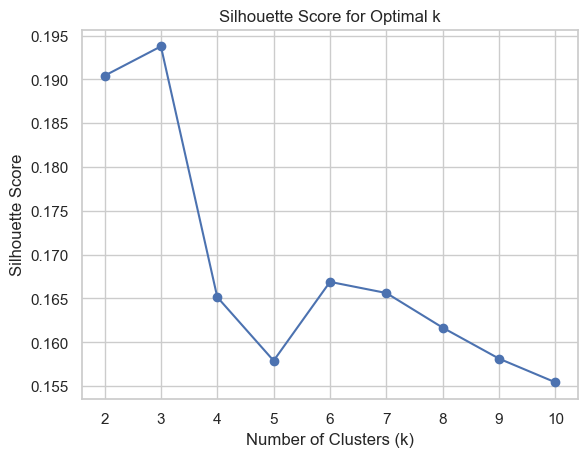

In [111]:
from sklearn.metrics import silhouette_score

silhouette_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    silhouette_scores.append(silhouette_score(X, kmeans.labels_))

# Plot the silhouette scores
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.title('Silhouette Score for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.show()

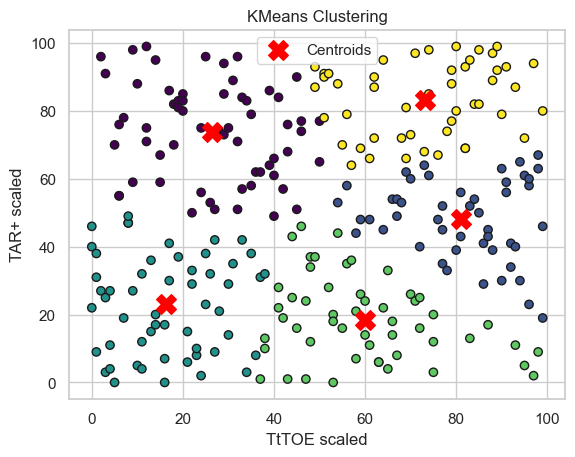

In [112]:
X = metrics_df[['TtTOE scaled',
       'TAR+ scaled']].values
# Create a KMeans clustering model with k=3 clusters
kmeans = KMeans(n_clusters=5, random_state=42)

# Fit the model to the data
kmeans.fit(X)

# Get cluster labels for each data point
labels = kmeans.labels_

# Visualize the clusters (for 2D data)
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', edgecolor='k')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', marker='X', s=200, label='Centroids')
plt.title('KMeans Clustering')
plt.xlabel('TtTOE scaled')
plt.ylabel('TAR+ scaled')
plt.legend()
plt.show()

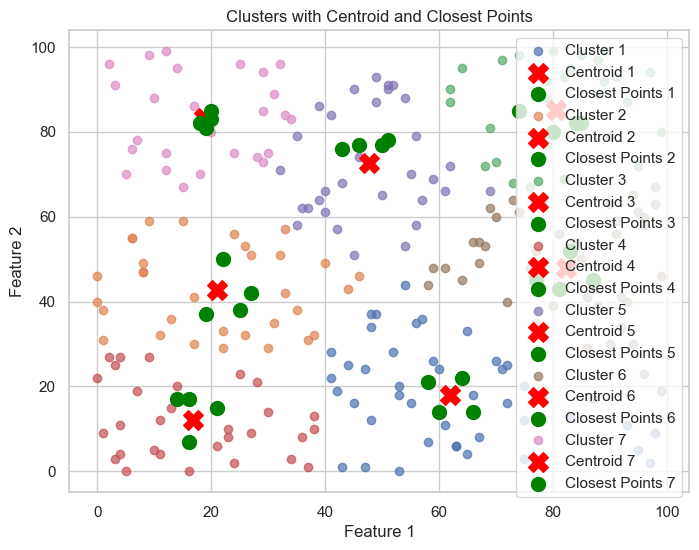

In [113]:
# Create a KMeans clustering model with the optimal number of clusters
optimal_k = 7  # Replace with the optimal number of clusters from your analysis
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans.fit(X)

# Find the 4 nearest neighbors (including the centroid) for each cluster
nearest_neighbors = NearestNeighbors(n_neighbors=5)
nearest_neighbors.fit(X)

# Get cluster labels and coordinates of all points
labels = kmeans.labels_
cluster_centers = kmeans.cluster_centers_
all_points = X

# Plot the clusters with centroid and 4 closest points
plt.figure(figsize=(8, 6))

for i in range(optimal_k):
    cluster_points_indices = nearest_neighbors.kneighbors([cluster_centers[i]])[1][0]
    
    # Plot all points in the cluster
    plt.scatter(all_points[labels == i][:, 0], all_points[labels == i][:, 1], label=f'Cluster {i + 1}', alpha=0.7)
    
    # Plot the centroid
    plt.scatter(cluster_centers[i, 0], cluster_centers[i, 1], marker='X', s=200, c='red', label=f'Centroid {i + 1}')
    
    # Plot the 4 closest points
    plt.scatter(all_points[cluster_points_indices[1:], 0], all_points[cluster_points_indices[1:], 1], marker='o', s=100, c='green', label=f'Closest Points {i + 1}')

plt.title('Clusters with Centroid and Closest Points')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.show()

In [114]:
# Create a figure
fig = go.Figure()

# Scatter plot
scatter_trace = go.Scatter(x=metrics_df['TtTOE'], y=metrics_df['TAR+'], mode='markers', text=metrics_df['displayName_defender'], showlegend=False,
                            marker=dict(color='gray',size = 6,opacity = 1))
fig.add_trace(scatter_trace)

# Add horizontal and vertical lines
fig.add_hline(y=metrics_df['TAR+'].mean(), line_color='red', line_width=2, line_dash="dash", name='Mean TAR+')
fig.add_vline(x=metrics_df['TtTOE'].mean(), line_color='red', line_width=2, line_dash="dash", name='Mean TtTOE')

# # Add background rectangles for each quintile
# quintile_colors = px.colors.qualitative.Set1[:4]  # You can choose a different color scheme
# legend_items = []  # List to store legend items

# for quartile in range(4):
#     lower_bound = metrics_df[metrics_df['TtTOE_quartiles'] == quartile]['TtTOE'].min()
#     upper_bound = metrics_df[metrics_df['TtTOE_quartiles'] == quartile]['TtTOE'].max()

#     # # Create invisible scatter trace for legend item
#     legend_trace = go.Scatter(
#         x=[None],
#         y=[None],
#         mode='markers',
#         marker=dict(color=quintile_colors[quartile], opacity=.4,
#                     size = 20,symbol='square'),
#         name=f'Quartile {quartile + 1}'
#     )
#     fig.add_trace(legend_trace)

#     # Add shape for the background rectangle
#     fig.add_shape(
#         type='rect',
#         x0=lower_bound,
#         y0=metrics_df['TAR+'].min() - 0.2,
#         x1=upper_bound,
#         y1=metrics_df['TAR+'].max() + 0.2,
#         fillcolor=quintile_colors[quartile],
#         opacity=0.4,
#         layer='below',
#         showlegend=True
#     )

# Set explicit range for x and y axes
fig.update_layout(
    xaxis=dict(range=[metrics_df['TtTOE'].min() - 0.5, metrics_df['TtTOE'].max() + 0.5], showgrid=False),
    yaxis=dict(range=[metrics_df['TAR+'].min() - 0.2, metrics_df['TAR+'].max() + 0.2], showgrid=False),
)

# Add annotations for above and below the median of 'TAR+'
median_tarplus = metrics_df['TAR+'].median()

fig.add_annotation(
    x=50,
    y=median_tarplus + 1,
    text='Above median tacklers',
    showarrow=False,
    ax=0,
    ay=-40,
    font=dict(size=20, color='black', family='Arial'),
)

fig.add_annotation(
    x=50,
    y=median_tarplus - 1,
    text='Below median tacklers',
    showarrow=False,
    ax=0,
    ay=40,
    font=dict(size=20, color='black', family='Arial'),
)

selected_players = ['Chuck Clark', 'Marcus Williams', 'Darious Williams', 'John Johnson', 'Bobby Wagner',
                    'Kristian Fulton']

annotations = []

for player in selected_players:
    metrics_player = metrics_df[metrics_df['displayName_defender'] == player]
    dict_ann = dict(
        x=metrics_player['TtTOE'].values[0],
        y=metrics_player['TAR+'].values[0],
        text=f"{player} Position: {metrics_player['position'].values[0]}",
        showarrow=True,
        arrowhead=1,
        arrowsize=1,
        arrowwidth=1,
        arrowcolor='black',
        ax=0,
        ay=-20,
        font=dict(size=12, color='black', family='Arial')
    )
    annotations.append(dict_ann)

for annotation in annotations:
    fig.add_annotation(**annotation)

fig.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1.02,
    xanchor="right",
    x=1
))
fig.update_layout(title_text="Estimated time to tackle opportuniy (eTTO) vs Tackling Above Replacement (TAR+) ", title_font=dict(size=24, family='Arial', color='black'))
fig.update_layout(
    xaxis_title="eTTO",
    yaxis_title="TAR+"
)
# Show the plot
fig.show()

In [115]:
dict_colors = {0:'blue',1:'red',2:'brown',3:'lightcoral'}
# Create a figure
fig = go.Figure()
for i in range(4):
    metrics_quartile = metrics_df[metrics_df['Quartiles']==i]
    hover_text = metrics_quartile.apply(lambda row: f"{row['displayName_defender']} - Position {row['position']}", axis=1)
# Scatter plot
    scatter_trace = go.Scatter(x=metrics_quartile['TtTOE'], y=metrics_quartile['TAR+'], mode='markers', text=hover_text, showlegend=True,
                                marker=dict(color=dict_colors[i],size = 6,opacity = 1), name= f'Quartile {i+1}'
                                )
    fig.add_trace(scatter_trace)

# Add horizontal and vertical lines
fig.add_hline(y=metrics_df['TAR+'].mean(), line_color='red', line_width=2, line_dash="dash", name='Mean TAR+')
fig.add_vline(x=metrics_df['TtTOE'].mean(), line_color='red', line_width=2, line_dash="dash", name='Mean TtTOE')

# Set explicit range for x and y axes
fig.update_layout(
    xaxis=dict(range=[metrics_df['TtTOE'].min() - 0.5, metrics_df['TtTOE'].max() + 0.5], showgrid=False),
    yaxis=dict(range=[metrics_df['TAR+'].min() - 0.2, metrics_df['TAR+'].max() + 0.2], showgrid=False),
)

# Add annotations for above and below the median of 'TAR+'
median_tarplus = metrics_df['TAR+'].median()

fig.add_annotation(
    x=50,
    y=median_tarplus + 1,
    text='Above median tacklers',
    showarrow=False,
    ax=0,
    ay=-40,
    font=dict(size=20, color='black', family='Arial'),
)

fig.add_annotation(
    x=50,
    y=median_tarplus - 1,
    text='Below median tacklers',
    showarrow=False,
    ax=0,
    ay=40,
    font=dict(size=20, color='black', family='Arial'),
)

selected_players = ['Chuck Clark', 'Marcus Williams', 'Darious Williams', 'John Johnson', 'Bobby Wagner',
                    'Kristian Fulton']

annotations = []

for player in selected_players:
    metrics_player = metrics_df[metrics_df['displayName_defender'] == player]
    dict_ann = dict(
        x=metrics_player['TtTOE'].values[0],
        y=metrics_player['TAR+'].values[0],
        text=f"{player} Position: {metrics_player['position'].values[0]}",
        showarrow=True,
        arrowhead=1,
        arrowsize=1,
        arrowwidth=1,
        arrowcolor='black',
        ax=0,
        ay=-10,
        font=dict(size=12, color='black', family='Arial')
    )
    annotations.append(dict_ann)

for annotation in annotations:
    fig.add_annotation(**annotation)

fig.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1.02,
    xanchor="right",
    x=1
))
fig.update_layout(title_text="Estimated time to tackle opportuniy (eTTO) vs Tackling Above Replacement (TAR+) ", title_font=dict(size=24, family='Arial', color='black'))
fig.update_layout(
    xaxis_title="eTTO",
    yaxis_title="TAR+"
)
# Show the plot
fig.show()

In [156]:
from plotly.subplots import make_subplots


# Create a figure with 2 rows and 1 column
fig = make_subplots(rows=3, cols=2, specs=[[{'colspan':2},None],
                                           [{"type": "table",
                                             'rowspan':2},{"type": "table",
                                             'rowspan':2}],
                                           [None,None]],
                                           subplot_titles=['','Top 12 LBs',
                                                           'Top 12 DBs'])

# Scatter plot
dict_colors = {0:'blue',1:'red',2:'brown',3:'lightcoral'}
for i in range(4):
    metrics_quartile = metrics_df[metrics_df['Quartiles'] == i]
    hover_text = metrics_quartile.apply(lambda row: f"{row['displayName_defender']} - Position {row['position']}", axis=1)
    scatter_trace = go.Scatter(x=metrics_quartile['TtTOE'], y=metrics_quartile['TAR+'], mode='markers', text=hover_text, showlegend=True,
                                marker=dict(color=dict_colors[i],size = 6,opacity = 1), name= f'Quartile {i+1}'
                                )
    fig.add_trace(scatter_trace, row=1, col=1)

# Add horizontal and vertical lines to Scatter plot
# fig.add_hline(y=metrics_df['TAR+'].mean(), line_color='red', line_width=2, line_dash="dash", name='Mean TAR+')
# fig.add_vline(x=metrics_df['TtTOE'].mean(), line_color='red', line_width=2, line_dash="dash", name='Mean TtTOE')

# Set explicit range for x and y axes for Scatter plot
fig.update_xaxes(range=[metrics_df['TtTOE'].min() - 0.5, metrics_df['TtTOE'].max() + 0.5], showgrid=False, row=1, col=1)
fig.update_yaxes(range=[metrics_df['TAR+'].min() - 0.2, metrics_df['TAR+'].max() + 0.2], showgrid=False, row=1, col=1)

# Add annotations for above and below the median of 'TAR+' to Scatter plot
median_tarplus = metrics_df['TAR+'].median()
fig.add_annotation(
    x=50,
    y=median_tarplus + 1,
    text='Above median tacklers',
    showarrow=False,
    ax=0,
    ay=-40,
    font=dict(size=20, color='black', family='Arial'),
    row=1, col=1
)

fig.add_annotation(
    x=50,
    y=median_tarplus - 1,
    text='Below median tacklers',
    showarrow=False,
    ax=0,
    ay=40,
    font=dict(size=20, color='black', family='Arial'),
    row=1, col=1
)
# Set explicit range for x and y axes
fig.update_layout(
    xaxis=dict(range=[metrics_df['TtTOE'].min() - 0.5, metrics_df['TtTOE'].max() + 0.5], showgrid=False),
    yaxis=dict(range=[metrics_df['TAR+'].min() - 0.2, metrics_df['TAR+'].max() + 0.2], showgrid=False),
)

# Add annotations for above and below the median of 'TAR+'
median_tarplus = metrics_df['TAR+'].median()

fig.add_annotation(
    x=50,
    y=median_tarplus + 1,
    text='Above median tacklers',
    showarrow=False,
    ax=0,
    ay=-40,
    font=dict(size=20, color='black', family='Arial'),
)

fig.add_annotation(
    x=50,
    y=median_tarplus - 1,
    text='Below median tacklers',
    showarrow=False,
    ax=0,
    ay=40,
    font=dict(size=20, color='black', family='Arial'),
)

selected_players = ['Chauncey Gardner-Johnson', 'Marcus Williams', 'Darious Williams', 'John Johnson', 'Bobby Wagner',
                    'Kristian Fulton','Jordan Hicks']

annotations = []

for player in selected_players:
    metrics_player = metrics_df[metrics_df['displayName_defender'] == player]
    dict_ann = dict(
        x=metrics_player['TtTOE'].values[0],
        y=metrics_player['TAR+'].values[0],
        text=f"{player} Position: {metrics_player['position'].values[0]}",
        showarrow=True,
        arrowhead=1,
        arrowsize=1,
        arrowwidth=1,
        arrowcolor='black',
        ax=0,
        ay=-10,
        font=dict(size=12, color='black', family='Arial')
    )
    annotations.append(dict_ann)

for annotation in annotations:
    fig.add_annotation(**annotation)

db_df = metrics_df[metrics_df['Position Group'] == 'DB'].sort_values('TAR + TtTOE', ascending=False).head(12)[
    ['displayName_defender', 'position','TtTOE scaled',
       'TAR+ scaled', 'TAR + TtTOE']].round(2)
lb_df = metrics_df[metrics_df['Position Group'] == 'DB'].sort_values('TAR + TtTOE', ascending=False).head(12)[
    ['displayName_defender', 'position','TtTOE scaled',
       'TAR+ scaled', 'TAR + TtTOE']].round(2)

# Add tables to subplot
fig.add_trace(go.Table(header=dict(values=['Player', 'Position','TtTOAR percentile',
                                            'TAR+ percentile', 'Composite Score'],
                        fill_color=dict_colors[0],
                        align='center',
                        font=dict(color='white', size=12)),
                      cells=dict(values=[db_df[col] for col in db_df.columns],
                                 height=24,
                                 font_size=10,
                                 align='left')
                      ), row=2, col=1)

fig.add_trace(go.Table(header=dict(values=['Player', 'Position','TtTOAR percentile',
                                            'TAR+ percentile', 'Composite Score'],
                        fill_color=dict_colors[0],
                        align='center',
                        font=dict(color='white', size=12)),
                      cells=dict(values=[db_df[col] for col in lb_df.columns],
                                 height=24,
                                 font_size=10,
                                 align='left')
                      ), row=2, col=2)

# Update layout
fig.update_layout(
    height=800,
    title_text="Estimated time to tackle opportuniy (eTTO) vs Tackling Above Replacement (TAR+)",
    title_font=dict(size=24, family='Arial', color='black'),
    xaxis_title="eTTO",
    yaxis_title="TAR+",
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1
    ),
)

# Show the plot
fig.show()
#fig.write_html('scatter_w_tables.html')

In [158]:
metrics_df.to_csv('metrics_df.csv',index=False)

In [164]:
metrics_df.columns

Index(['displayName_defender', 'nflId_defender', 'TtTOE', 'play', 'tackle',
       'missed', 'TAR', 'TAR+', 'TtTOE per play', 'TtTOE scaled',
       'TAR+ scaled', 'TAR + TtTOE', 'Diff', 'position', 'Quartiles',
       'Position Group'],
      dtype='object')